## Setup

In [1]:
%matplotlib inline

In [2]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo
from aif360.metrics import BinaryLabelDatasetMetric
from oversample import label_bias, selection_bias 
from sklearn import preprocessing
from privacy_meter.dataset import Dataset
from aif360.datasets import BinaryLabelDataset
import os
import shutil
import glob
from datetime import datetime

## Arguments & Initializations

In [3]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex', 'law_race', 'law_aif_gender', 'law_aif_race'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")
ap.add_argument("-a", "--attack", choices=['mia1', 'mia2'], default='mia1', help="attacks: our implementation, their implementation")

_StoreAction(option_strings=['-a', '--attack'], dest='attack', nargs=None, const=None, default='mia1', type=None, choices=['mia1', 'mia2'], required=False, help='attacks: our implementation, their implementation', metavar=None)

In [4]:
sys.argv = ['']
args = vars(ap.parse_args())

In [5]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2,
 'attack': 'mia1'}

In [6]:
DATASET = "bank"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])
ATTACK = "mia2"

In [7]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 20

# cpp_metrics = defaultdict(list) 
# cpp_mia_metrics = defaultdict(list)

# pr_orig_metrics = defaultdict(list) 
# ro_metrics = defaultdict(list) 

In [8]:
# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

eg_metrics = defaultdict(list) 
eg_mia_metrics = defaultdict(list) 

## Loading & Splitting Dataset

In [9]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

In [10]:
dataset_orig.features.shape

(30448, 57)

In [11]:
privileged_groups

[{'age': 1}]

In [12]:
sens_attr

'age'

In [13]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

In [14]:
if ATTACK == "mia1":
    # training data split ratio
    p = 0.5
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print(dataset_orig_train.features)

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')
        
    dataset_orig_train
    dataset_orig_train?

## Run Mitigating Algorithms

### Setup for MIA2

In [15]:
seed = 1234
np.random.seed(seed)

In [16]:
if ATTACK == "mia2":
    # prepare data format
    X = dataset_orig.features
    y_true = dataset_orig.labels.ravel()
    sens_attr = dataset_orig.protected_attribute_names[0]
    sens_attr_index = dataset_orig.feature_names.index(sens_attr)
    sensitive_features = dataset_orig.features[:, sens_attr_index]

    X_other_features = np.delete(X, sens_attr_index, axis=1)
    X_other_features_normalized = preprocessing.normalize(X_other_features, norm='l2')

    # Reconstruct X by combining the sensitive attribute and the normalized features
    # Insert the sensitive attribute back into its original position
    X_normalized = np.insert(X_other_features_normalized, sens_attr_index, sensitive_features, axis=1)
    X = X_normalized

In [17]:
def get_unique_indices_reference():
    # Determine split sizes proportionally (to sum up to the full dataset size)
    num_train_points = int(X.shape[0] * 0.12)
    num_test_points = int(X.shape[0] * 0.12)
    num_population_points = int(X.shape[0] * 0.3)  # Reduced from 30000

    # Start with all indices
    all_indices = np.arange(X.shape[0])

    # Select train indices without replacement
    train_index = np.random.choice(all_indices, num_train_points, replace=False)
    # Remove train indices from available indices
    remaining_indices = np.setdiff1d(all_indices, train_index)

    # Select test indices from the remaining indices without replacement
    test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
    # Remove test indices from available indices
    remaining_indices = np.setdiff1d(remaining_indices, test_index)

    # Select population indices from the remaining indices (can also choose all remaining points)
    population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)
    
    # Summary of counts
    print("==============================================================")
    print("GET UNIQUE INDICES REFERENCE")
    print(f"Number of train points: {len(train_index)}")
    print(f"Number of test points: {len(test_index)}")
    print(f"Number of population points: {len(population_index)}")
    print("==============================================================")
    
    return train_index, test_index, population_index

In [18]:
def create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train):
    # create the target model's dataset
    train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
    test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
    target_dataset = Dataset(
        data_dict={'train': train_ds, 'test': test_ds},
        default_input='x', default_output='y', default_group='g'
    )

    # create the reference dataset
    population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
    reference_dataset = Dataset(
        data_dict={'train': population_ds},
        default_input='x', default_output='y', default_group='g'
    )
    
    return target_dataset, reference_dataset

In [19]:
# Combine features, labels, and protected attributes into a DataFrame
def create_binary_label_dataset(dataset_orig, X, y, sensitive_features, sens_attr_name, privileged_value, unprivileged_value):
    print("=====================================================")
    print("CREATE BINARY LABEL DATASET")
    # Extract the feature names from the original dataset
    feature_names = dataset_orig.feature_names

    # Create a DataFrame with features, labels, and sensitive attribute
    df = pd.DataFrame(X, columns=feature_names)
    df[dataset_orig.label_names[0]] = y
#     print(df.head())
    # print(dataset_orig.feature_names)
    # print(dataset_orig.features.shape)
    
    # df_orig, _ = dataset_orig.convert_to_dataframe()

    # # Display the first few rows
    # print("Original df's head:", df_orig.head())
    
    # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset_orig.labels, return_counts=True)

    # # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")

    # Create the BinaryLabelDataset
    dataset = BinaryLabelDataset(
        favorable_label=1.0,  # Adjust as per your dataset
        unfavorable_label=0.0,  # Adjust as per your dataset
        df=df,  # DataFrame containing features, labels, and protected attribute
        label_names=dataset_orig.label_names,  # Column name of labels in DataFrame
        protected_attribute_names=[sens_attr_name],  # Protected attribute column
        privileged_protected_attributes=[privileged_value],  # Privileged group values
        unprivileged_protected_attributes=[unprivileged_value]  # Unprivileged group values
    )
    
    # print(dataset.feature_names)
    # print(dataset.features.shape)
    # # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset.labels, return_counts=True)

    # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")
    
    print("=====================================================")
    
    return dataset

In [20]:
def delete_logs():
    # Search for directories ending with _group or _pop
    for pattern in ["*_group", "*_pop"]:
        # Find matching directories
        for log_dir in glob.glob(pattern):
            if os.path.exists(log_dir) and os.path.isdir(log_dir):  # Ensure it's a directory
                shutil.rmtree(log_dir)
                print(f"{log_dir} deleted.")

### Calling Both

In [21]:
# target_dataset = None
# reference_dataset = None

In [22]:
import warnings
warnings.filterwarnings("ignore")

In [23]:
def prepare_datasets():
    target_dataset = None
    reference_dataset = None
    
    if ATTACK == "mia1":
        # split dataset into train, validation, and test
        dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
        dataset_orig_val = dataset_orig_test

    elif ATTACK == "mia2":
        train_index, test_index, population_index = get_unique_indices_reference()

        g_train = y_true[train_index] + (sensitive_features[train_index] + 1) * 2 # 2, 4, 3, 5
        g_test = y_true[test_index] + (sensitive_features[test_index] + 1) * 2
        g_pop_train = y_true[population_index] + (sensitive_features[population_index] + 1) * 2

        # for Audit
        target_dataset, reference_dataset = create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train)

        # for mitigators
        privileged_value = [1]
        unprivileged_value = [0]
        # Convert train dataset
        dataset_orig_train = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[train_index],
            y=y_true[train_index],
            sensitive_features=sensitive_features[train_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
#         dataset_orig_val = create_binary_label_dataset(
#             dataset_orig=dataset_orig,
#             X=X[valid_index],
#             y=y_true[valid_index],
#             sensitive_features=sensitive_features[valid_index],
#             sens_attr_name=sens_attr,
#             privileged_value=privileged_value,
#             unprivileged_value=unprivileged_value
#         )

        # Convert test dataset
        dataset_orig_test = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[test_index],
            y=y_true[test_index],
            sensitive_features=sensitive_features[test_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        dataset_orig_val = dataset_orig_test
        
    return dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset

In [24]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

try:
    # run mitigating algorithms
    for i in range(N):
        print('ITERATION ', i)
        dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()

        # check fairness on the original data
        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
        base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
        base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        print("DIFFERENCE IS GOOD")
        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        # favorable and unfavorable labels and feature_names
        f_label = dataset_orig.favorable_label
        uf_label = dataset_orig.unfavorable_label
        feature_names = dataset_orig.feature_names

        # introduce label or selection biases, assuming the original data is fair
        if BIAS_TYPE == 'label':
            dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
        elif BIAS_TYPE == 'selection':
            dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
        else:
            print('no bias type specified')

        # show data info
        print("#### Training Dataset shape")
        print(dataset_orig_train.features.shape)
        print("#### Favorable and unfavorable labels")
        print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
        print("#### Protected attribute names")
        print(dataset_orig_train.protected_attribute_names)
        print("#### Privileged and unprivileged protected groups")
        print(privileged_groups, unprivileged_groups)
        print("#### Privileged and unprivileged protected attribute values")
        print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
        print("#### Dataset feature names")
        print(dataset_orig_train.feature_names)
        print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
        print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

        # statistics of favored/positive class BEFORE transf 
        priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
        priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
        favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
        favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
        favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
        favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

        print("#### Train shape, validation shape, test shape")
        print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

        # testing mitigation methods 
        test_cases = TestAlgorithms(BASELINE)

        # null mitigator
        orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # synthetic data mitigator
        metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)

        # statistics of favored/positive class AFTER transf
        favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
        favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
        favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
        favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

        # dir mitigator
        dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # reweigh mitigator
        reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # eg mitigator, in-processing
        eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # cpp mitigator
    #     cpp_metrics, cpp_mia_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, cpp_metrics, cpp_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        delete_logs()
except ValueError as e:
    print("Error detected: No samples generated. Adjusting datasets...")
    delete_logs()
    # percentage of favor and unfavor
    priv_metric_orig = defaultdict(float)
    favor_metric_orig = defaultdict(float)
    favor_metric_transf = defaultdict(float)

    # for each pre-processing approach, we create a mia_metric_results
    orig_metrics = defaultdict(list)
    orig_mia_metrics = defaultdict(list)

    transf_metrics = defaultdict(list) 
    transf_mia_metrics = defaultdict(list) 

    reweigh_metrics = defaultdict(list) 
    reweigh_mia_metrics = defaultdict(list) 

    dir_metrics = defaultdict(list) 
    dir_mia_metrics = defaultdict(list) 

    eg_metrics = defaultdict(list) 
    eg_mia_metrics = defaultdict(list) 
    # run mitigating algorithms
    for i in range(N):
        print('ITERATION ', i)
        dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()

        # check fairness on the original data
        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)
        print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
        base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
        base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        while(base_rate_privileged >= base_rate_unprivileged and (base_rate_privileged - base_rate_unprivileged) <= 0.05):
            print("DIFFERENCE IS TOO LOW, GETTING DATASETS AGAIN")
            dataset_orig_train, dataset_orig_val, dataset_orig_test, target_dataset, reference_dataset = prepare_datasets()
             # check fairness on the original data
            metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                         unprivileged_groups=unprivileged_groups,
                                                         privileged_groups=privileged_groups)
            print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
            base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
            base_rate_privileged = metric_orig_train.base_rate(privileged=True)

        print("DIFFERENCE IS GOOD")
        print('base_pos unpriv: ', base_rate_unprivileged)
        print('base_pos priv: ', base_rate_privileged)

        # favorable and unfavorable labels and feature_names
        f_label = dataset_orig.favorable_label
        uf_label = dataset_orig.unfavorable_label
        feature_names = dataset_orig.feature_names

        # introduce label or selection biases, assuming the original data is fair
        if BIAS_TYPE == 'label':
            dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
        elif BIAS_TYPE == 'selection':
            dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
        else:
            print('no bias type specified')

        # show data info
        print("#### Training Dataset shape")
        print(dataset_orig_train.features.shape)
        print("#### Favorable and unfavorable labels")
        print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
        print("#### Protected attribute names")
        print(dataset_orig_train.protected_attribute_names)
        print("#### Privileged and unprivileged protected groups")
        print(privileged_groups, unprivileged_groups)
        print("#### Privileged and unprivileged protected attribute values")
        print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
        print("#### Dataset feature names")
        print(dataset_orig_train.feature_names)
        print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
        print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

        # statistics of favored/positive class BEFORE transf 
        priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
        priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
        favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
        favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
        favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
        favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
        favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

        print("#### Train shape, validation shape, test shape")
        print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

        # testing mitigation methods 
        test_cases = TestAlgorithms(BASELINE)

        # null mitigator
        orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 
        print("ORIG MIA METRICS ", orig_mia_metrics)
        
        # synthetic data mitigator
        metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)

        # statistics of favored/positive class AFTER transf
        favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
        favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
        favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
        favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
        favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

        # dir mitigator
        dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

        # reweigh mitigator
        reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # eg mitigator, in-processing
        eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        # cpp mitigator
    #     cpp_metrics, cpp_mia_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, cpp_metrics, cpp_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

        delete_logs()

ITERATION  0
GET UNIQUE INDICES REFERENCE
Number of train points: 3653
Number of test points: 3653
Number of population points: 9134
CREATE BINARY LABEL DATASET
CREATE BINARY LABEL DATASET
privileged vs. unprivileged:  3446.0 207.0
base_pos unpriv:  0.34299516908212563
base_pos priv:  0.12100986651189785
DIFFERENCE IS GOOD
base_pos unpriv:  0.34299516908212563
base_pos priv:  0.12100986651189785
no bias type specified
#### Training Dataset shape
(3653, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected groups
[{'age': 1}] [{'age': 0}]
#### Privileged and unprivileged protected attribute values
[[1]] [[0]]
#### Dataset feature names
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job=admin.', 'job=blue-collar', 'job=entrepreneur', 'job=housemaid', 'job=management', 'job=retired', 'job=self-employed', 'job=services', 'job=st

DATAFRAME BEFORE DIR TRANSFORM       age  duration  campaign     pdays  previous  emp.var.rate  \
0     1.0  0.040540  0.000563  0.187497       0.0      0.000263   
1     1.0  0.005696  0.000196  0.196202       0.0     -0.000334   
2     0.0  0.021934  0.000756  0.188901       0.0      0.000208   
3     1.0  0.004810  0.000770  0.192221       0.0     -0.000346   
4     1.0  0.032292  0.000375  0.187554       0.0      0.000263   
...   ...       ...       ...       ...       ...           ...   
3648  1.0  0.030248  0.000567  0.188860       0.0      0.000208   
3649  1.0  0.026352  0.000385  0.192157       0.0     -0.000346   
3650  1.0  0.030979  0.000188  0.187562       0.0      0.000263   
3651  1.0  0.008077  0.000188  0.187648       0.0      0.000263   
3652  1.0  0.131987  0.000191  0.190541       0.0     -0.000343   

      cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month=sep  \
0           0.017730      -0.007845   0.000931     0.981236  ...        0.0   
1     

Best thresh:  [0.01749316]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.06
  Positive predictive value: 0.52
  Optimal thershold: [0.84729786]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 136, Test = 159
  AUC: 0.58
  Privacy Risk: 0.58
  Accuracy: 0.59
  Train Accuracy (TPR): 0.50
  Test Accuracy (TNR): 0.66
  Attacker advantage: 0.16
  Positive predictive value: 0.56
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 71, Test = 78
  AUC: 0.56
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.48
  Test Accuracy (TNR): 0.64
  Attacker advantage: 0.12
  Positive predictive value: 0.55
  Optimal thershold: [0.31845373]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the D

RUN MIA2 ATTACK
Results are stored in: ['un_log_group']
Results are stored in: ['un_log_pop']
TEST
Best thresh:  [0.01980263]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: [0.7472144]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 135, Test = 144
  AUC: 0.54
  Privacy Risk: 0.55
  Accuracy: 0.54
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.10
  Positive predictive value: 0.52
  Optimal thershold: [0.18232156]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 63, Test = 80
  AUC: 0.64
  Privacy Risk: 0.62
  Accuracy: 0.62
  Train Accuracy (TPR): 0.57
  Test Accuracy (TNR): 0.66
  Attacker advantage: 0.23
  Positive predictive value: 0.71
 

DATAFRAME BEFORE DIR TRANSFORM       age  duration  campaign     pdays  previous  emp.var.rate  \
0     1.0  0.016903  0.000376  0.187625  0.000000      0.000263   
1     1.0  0.002442  0.002066  0.187653  0.000000      0.000263   
2     1.0  0.042869  0.000384  0.192047  0.000192     -0.000346   
3     1.0  0.002117  0.001732  0.192223  0.000000     -0.000346   
4     1.0  0.019046  0.000192  0.192188  0.000000     -0.000346   
...   ...       ...       ...       ...       ...           ...   
3648  1.0  0.006827  0.000190  0.189457  0.000000     -0.000038   
3649  1.0  0.028353  0.000188  0.187578  0.000000      0.000263   
3650  1.0  0.022501  0.000189  0.188898  0.000000      0.000208   
3651  1.0  0.014373  0.000756  0.188927  0.000000      0.000208   
3652  1.0  0.029811  0.000192  0.192138  0.000000     -0.000346   

      cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month=sep  \
0           0.017639      -0.008020   0.000932     0.981903  ...        0.0   
1     

Best thresh:  [0.08004271]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.06
  Positive predictive value: 0.52
  Optimal thershold: [0.82667857]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 135, Test = 144
  AUC: 0.55
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.38
  Attacker advantage: 0.12
  Positive predictive value: 0.53
  Optimal thershold: [0.22314355]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 63, Test = 80
  AUC: 0.72
  Privacy Risk: 0.70
  Accuracy: 0.69
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.60
  Attacker advantage: 0.39
  Positive predictive value: 0.65
  Optimal thershold: [0.78845736]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the D

Results are stored in: ['un_log_pop']
TEST
Best thresh:  [0.00836825]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.03
  Positive predictive value: 0.53
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 138, Test = 132
  AUC: 0.57
  Privacy Risk: 0.59
  Accuracy: 0.60
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.25
  Attacker advantage: 0.18
  Positive predictive value: 0.57
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 72, Test = 56
  AUC: 0.60
  Privacy Risk: 0.59
  Accuracy: 0.63
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.27
  Attacker advantage: 0.22
  Positive predictive value: 0.65
  Optimal thershold: [0.58778666]
)
MIA_Result(
  Name: 

DATAFRAME BEFORE DIR TRANSFORM       age  duration  campaign     pdays  previous  emp.var.rate  \
0     1.0  0.077121  0.000384  0.191651  0.000192     -0.000345   
1     1.0  0.053607  0.000192  0.191947  0.000000     -0.000346   
2     1.0  0.090448  0.000192  0.191435  0.000000     -0.000345   
3     1.0  0.006762  0.000376  0.187647  0.000000      0.000263   
4     1.0  0.052426  0.000199  0.001993  0.000399     -0.000359   
...   ...       ...       ...       ...       ...           ...   
3648  1.0  0.178180  0.000185  0.184649  0.000000      0.000259   
3649  1.0  0.053215  0.000195  0.194734  0.000195     -0.000585   
3650  1.0  0.010143  0.000939  0.187644  0.000000      0.000263   
3651  1.0  0.065282  0.000192  0.191813  0.000000     -0.000346   
3652  1.0  0.046908  0.000563  0.187445  0.000000      0.000263   

      cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month=sep  \
0           0.017821      -0.008863   0.000256     0.978226  ...        0.0   
1     

Best thresh:  [0.02666825]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.21
  Attacker advantage: 0.05
  Positive predictive value: 0.52
  Optimal thershold: [0.31845373]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 138, Test = 132
  AUC: 0.59
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.63
  Test Accuracy (TNR): 0.52
  Attacker advantage: 0.15
  Positive predictive value: 0.58
  Optimal thershold: [0.22314355]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 72, Test = 56
  AUC: 0.67
  Privacy Risk: 0.61
  Accuracy: 0.66
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.23
  Attacker advantage: 0.25
  Positive predictive value: 0.74
  Optimal thershold: [0.85458674]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the D

RUN MIA2 ATTACK
Results are stored in: ['un_log_group']
Results are stored in: ['un_log_pop']
TEST
Best thresh:  [0.03974033]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.06
  Positive predictive value: 0.54
  Optimal thershold: [0.77318989]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 129, Test = 145
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.48
  Test Accuracy (TNR): 0.59
  Attacker advantage: 0.11
  Positive predictive value: 0.51
  Optimal thershold: [0.91629073]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 52, Test = 78
  AUC: 0.60
  Privacy Risk: 0.50
  Accuracy: 0.60
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.22
  Positive predictive value: 0.50


DATAFRAME BEFORE DIR TRANSFORM       age  duration  campaign     pdays  previous  emp.var.rate  \
0     1.0  0.037754  0.000196  0.195422  0.000000     -0.000352   
1     1.0  0.080138  0.000374  0.187050  0.000000      0.000262   
2     1.0  0.065664  0.000192  0.191807  0.000000     -0.000346   
3     1.0  0.096487  0.000376  0.187896  0.000000     -0.000019   
4     1.0  0.084127  0.000974  0.194543  0.000000     -0.000662   
...   ...       ...       ...       ...       ...           ...   
3648  1.0  0.024412  0.000188  0.187596  0.000000      0.000263   
3649  1.0  0.017279  0.000188  0.187624  0.000000      0.000263   
3650  1.0  0.020846  0.000563  0.187613  0.000000      0.000263   
3651  1.0  0.020873  0.000197  0.000591  0.000394     -0.000571   
3652  0.0  0.090840  0.000192  0.192264  0.000000     -0.000558   

      cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month=sep  \
0           0.018364      -0.007825   0.000133     0.979789  ...        0.0   
1     

Best thresh:  [0.055673]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.05
  Positive predictive value: 0.53
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 129, Test = 145
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.53
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.10
  Positive predictive value: 0.52
  Optimal thershold: [0.37948962]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 52, Test = 78
  AUC: 0.63
  Privacy Risk: 0.50
  Accuracy: 0.60
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.29
  Positive predictive value: 0.49
  Optimal thershold: [1.2039728]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the Data

RUN MIA2 ATTACK
Results are stored in: ['un_log_group']
Results are stored in: ['un_log_pop']
TEST
Best thresh:  [0.02666825]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.05
  Positive predictive value: 0.54
  Optimal thershold: [0.72501656]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 140, Test = 145
  AUC: 0.52
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.81
  Test Accuracy (TNR): 0.27
  Attacker advantage: 0.08
  Positive predictive value: 0.52
  Optimal thershold: [0.40546511]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 74, Test = 85
  AUC: 0.60
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.59
  Test Accuracy (TNR): 0.59
  Attacker advantage: 0.22
  Positive predictive value: 0.56


DATAFRAME BEFORE DIR TRANSFORM       age  duration  campaign     pdays  previous  emp.var.rate  \
0     1.0  0.017209  0.000567  0.188918  0.000000      0.000208   
1     1.0  0.035958  0.000192  0.192099  0.000192     -0.000346   
2     1.0  0.006998  0.000567  0.188942  0.000000      0.000208   
3     1.0  0.053072  0.000378  0.188680  0.000000      0.000208   
4     1.0  0.014814  0.001154  0.192202  0.000000     -0.000346   
...   ...       ...       ...       ...       ...           ...   
3648  0.0  0.033958  0.000393  0.196092  0.000196     -0.000334   
3649  1.0  0.071706  0.000193  0.192565  0.000000     -0.000559   
3650  1.0  0.004132  0.000188  0.187652  0.000000      0.000263   
3651  0.0  0.029043  0.000385  0.192142  0.000000     -0.000346   
3652  1.0  0.034730  0.000751  0.187540  0.000000      0.000263   

      cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month=sep  \
0           0.017775      -0.006884   0.000918     0.981656  ...        0.0   
1     

Best thresh:  [0.01739174]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.21
  Attacker advantage: 0.05
  Positive predictive value: 0.52
  Optimal thershold: [0.26236426]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 140, Test = 145
  AUC: 0.54
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.17
  Attacker advantage: 0.11
  Positive predictive value: 0.52
  Optimal thershold: [1.16315081]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 74, Test = 85
  AUC: 0.60
  Privacy Risk: 0.62
  Accuracy: 0.60
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.24
  Positive predictive value: 0.56
  Optimal thershold: [0.98991222]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the D

Results are stored in: ['un_log_group']
Results are stored in: ['un_log_pop']
TEST
Best thresh:  [0.00870833]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 144, Test = 145
  AUC: 0.49
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.11
  Positive predictive value: 0.53
  Optimal thershold: [0.32439694]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 70, Test = 68
  AUC: 0.64
  Privacy Risk: 0.62
  Accuracy: 0.62
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.24
  Positive predictive value: 0.62
  Optimal thersh

DATAFRAME BEFORE DIR TRANSFORM       age  duration  campaign     pdays  previous  emp.var.rate  \
0     1.0  0.002694  0.001539  0.192223  0.000000     -0.000346   
1     1.0  0.040950  0.000577  0.192062  0.000000     -0.000346   
2     1.0  0.032325  0.000189  0.188847  0.000000      0.000208   
3     1.0  0.058087  0.000199  0.001194  0.000199     -0.000676   
4     1.0  0.029492  0.000945  0.188864  0.000000      0.000208   
...   ...       ...       ...       ...       ...           ...   
3648  0.0  0.293228  0.000184  0.183773  0.000184     -0.000331   
3649  1.0  0.113286  0.000560  0.186446  0.000000      0.000261   
3650  1.0  0.095576  0.000192  0.191343  0.000000     -0.000345   
3651  1.0  0.009579  0.000376  0.187645  0.000000      0.000263   
3652  1.0  0.041008  0.000945  0.188787  0.000000      0.000208   

      cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month=sep  \
0           0.017874      -0.008890   0.000250     0.981143  ...        0.0   
1     

Best thresh:  [0.04604394]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.06
  Positive predictive value: 0.56
  Optimal thershold: [0.77318989]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 144, Test = 145
  AUC: 0.54
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.62
  Test Accuracy (TNR): 0.48
  Attacker advantage: 0.11
  Positive predictive value: 0.55
  Optimal thershold: [0.2565495]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 70, Test = 68
  AUC: 0.71
  Privacy Risk: 0.69
  Accuracy: 0.70
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.39
  Positive predictive value: 0.71
  Optimal thershold: [0.78845736]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the Da

Results are stored in: ['un_log_group']
Results are stored in: ['un_log_pop']
TEST
Best thresh:  [0.01212136]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 137, Test = 132
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.36
  Attacker advantage: 0.14
  Positive predictive value: 0.58
  Optimal thershold: [0.28768207]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 62, Test = 69
  AUC: 0.60
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.31
  Test Accuracy (TNR): 0.83
  Attacker advantage: 0.15
  Positive predictive value: 0.61
  Optimal thersh

DATAFRAME BEFORE DIR TRANSFORM       age  duration  campaign     pdays  previous  emp.var.rate  \
0     1.0  0.002694  0.000385  0.192223  0.000000     -0.000346   
1     1.0  0.018327  0.000189  0.188745  0.000000     -0.000019   
2     1.0  0.053300  0.000393  0.000590  0.000197     -0.000570   
3     1.0  0.100546  0.000187  0.186701  0.000000      0.000262   
4     1.0  0.032296  0.000189  0.188679  0.000000     -0.000019   
...   ...       ...       ...       ...       ...           ...   
3648  1.0  0.015401  0.000188  0.187629  0.000000      0.000263   
3649  1.0  0.076601  0.001311  0.187102  0.000000      0.000262   
3650  1.0  0.062105  0.000566  0.188581  0.000000      0.000208   
3651  1.0  0.160114  0.000190  0.189744  0.000190     -0.000342   
3652  1.0  0.028915  0.000188  0.187573  0.000000      0.000263   

      cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month=sep  \
0           0.017874      -0.008890   0.000241     0.981144  ...        0.0   
1     

Best thresh:  [0.00390371]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.06
  Positive predictive value: 0.54
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 137, Test = 132
  AUC: 0.55
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.26
  Attacker advantage: 0.13
  Positive predictive value: 0.55
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 62, Test = 69
  AUC: 0.61
  Privacy Risk: 0.63
  Accuracy: 0.62
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.35
  Attacker advantage: 0.27
  Positive predictive value: 0.56
  Optimal thershold: [1.65384069]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the D

Results are stored in: ['un_log_group']
Results are stored in: ['un_log_pop']
TEST
Best thresh:  [0.03278982]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: [0.77318989]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 128, Test = 149
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.54
  Train Accuracy (TPR): 0.32
  Test Accuracy (TNR): 0.73
  Attacker advantage: 0.06
  Positive predictive value: 0.51
  Optimal thershold: [0.16705408]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 75, Test = 58
  AUC: 0.51
  Privacy Risk: 0.58
  Accuracy: 0.63
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.16
  Attacker advantage: 0.16
  Positive predictive value: 0.60
  Optimal thersh

DATAFRAME BEFORE DIR TRANSFORM       age  duration  campaign     pdays  previous  emp.var.rate  \
0     1.0  0.018343  0.000378  0.188914  0.000000      0.000208   
1     1.0  0.027625  0.000580  0.192986  0.000193     -0.000560   
2     1.0  0.002818  0.002818  0.187650  0.000000      0.000263   
3     0.0  0.042906  0.000390  0.194830  0.000000     -0.000585   
4     1.0  0.007181  0.000378  0.188772  0.000000     -0.000019   
...   ...       ...       ...       ...       ...           ...   
3648  1.0  0.031354  0.000751  0.187561  0.000000      0.000263   
3649  1.0  0.037234  0.000189  0.188815  0.000000      0.000208   
3650  1.0  0.006430  0.000757  0.188942  0.000000      0.000208   
3651  1.0  0.093298  0.000192  0.191385  0.000000     -0.000345   
3652  1.0  0.018781  0.000188  0.187619  0.000000      0.000263   

      cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month=sep  \
0           0.017775      -0.006883   0.000918     0.981636  ...        0.0   
1     

Best thresh:  [0.00105652]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.05
  Positive predictive value: 0.53
  Optimal thershold: [0.91629073]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 128, Test = 149
  AUC: 0.63
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.59
  Test Accuracy (TNR): 0.61
  Attacker advantage: 0.20
  Positive predictive value: 0.57
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 75, Test = 58
  AUC: 0.70
  Privacy Risk: 0.70
  Accuracy: 0.71
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.66
  Attacker advantage: 0.40
  Positive predictive value: 1.00
  Optimal thershold: [0.52951498]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the D

Results are stored in: ['un_log_group']
Results are stored in: ['un_log_pop']
TEST
Best thresh:  [0.01860519]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.04
  Positive predictive value: 0.58
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 141, Test = 148
  AUC: 0.56
  Privacy Risk: 0.57
  Accuracy: 0.56
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.14
  Positive predictive value: 0.56
  Optimal thershold: [0.5389965]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 68, Test = 53
  AUC: 0.60
  Privacy Risk: 0.61
  Accuracy: 0.65
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.26
  Attacker advantage: 0.22
  Positive predictive value: 0.66
  Optimal thersho

DATAFRAME BEFORE DIR TRANSFORM       age  duration  campaign     pdays  previous  emp.var.rate  \
0     1.0  0.094051  0.000391  0.195336  0.000782     -0.000332   
1     1.0  0.022160  0.000376  0.187606  0.000000      0.000263   
2     0.0  0.001732  0.001154  0.192223  0.000000     -0.000346   
3     1.0  0.102674  0.000396  0.001189  0.000198     -0.000674   
4     1.0  0.027313  0.000962  0.192151  0.000000     -0.000346   
...   ...       ...       ...       ...       ...           ...   
3648  1.0  0.001732  0.000577  0.192223  0.000192     -0.000346   
3649  1.0  0.022347  0.000563  0.187605  0.000000      0.000263   
3650  1.0  0.052522  0.000188  0.187393  0.000000      0.000263   
3651  1.0  0.019815  0.000385  0.192186  0.000192     -0.000346   
3652  0.0  0.014237  0.000385  0.192204  0.000000     -0.000346   

      cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month=sep  \
0           0.018385      -0.007489   0.000176     0.976014  ...        0.0   
1     

Best thresh:  [0.06062462]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.21
  Attacker advantage: 0.06
  Positive predictive value: 0.52
  Optimal thershold: [0.28768207]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 141, Test = 148
  AUC: 0.60
  Privacy Risk: 0.61
  Accuracy: 0.61
  Train Accuracy (TPR): 0.61
  Test Accuracy (TNR): 0.60
  Attacker advantage: 0.21
  Positive predictive value: 0.59
  Optimal thershold: [0.35667494]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 68, Test = 53
  AUC: 0.56
  Privacy Risk: 0.60
  Accuracy: 0.64
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.26
  Attacker advantage: 0.21
  Positive predictive value: 0.62
  Optimal thershold: [1.38629436]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the D

Results are stored in: ['un_log_group']
Results are stored in: ['un_log_pop']
TEST
Best thresh:  [0.03636764]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.21
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: [0.23052366]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 146, Test = 137
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.54
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.06
  Positive predictive value: 0.55
  Optimal thershold: [1.2039728]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 73, Test = 63
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0.60
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.15
  Positive predictive value: 0.66
  Optimal thersho

DATAFRAME BEFORE DIR TRANSFORM       age  duration  campaign     pdays  previous  emp.var.rate  \
0     1.0  0.013711  0.000188  0.187634  0.000000      0.000263   
1     1.0  0.014650  0.000751  0.187631  0.000000      0.000263   
2     1.0  0.044404  0.000192  0.192034  0.000000     -0.000346   
3     1.0  0.012698  0.000192  0.192208  0.000192     -0.000346   
4     1.0  0.009267  0.000189  0.188938  0.000000      0.000208   
...   ...       ...       ...       ...       ...           ...   
3648  1.0  0.020095  0.001878  0.187613  0.000000      0.000263   
3649  1.0  0.155495  0.000557  0.185369  0.000000      0.000260   
3650  1.0  0.139222  0.000374  0.186939  0.000000     -0.000019   
3651  1.0  0.017279  0.000563  0.187624  0.000000      0.000263   
3652  1.0  0.017587  0.000378  0.188917  0.000000      0.000208   

      cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month=sep  \
0           0.017640      -0.008020   0.000932     0.981951  ...        0.0   
1     

Best thresh:  [0.01589437]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.82
  Test Accuracy (TNR): 0.23
  Attacker advantage: 0.05
  Positive predictive value: 0.53
  Optimal thershold: [0.19415601]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 146, Test = 137
  AUC: 0.56
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.43
  Attacker advantage: 0.16
  Positive predictive value: 0.58
  Optimal thershold: [0.26826399]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 73, Test = 63
  AUC: 0.64
  Privacy Risk: 0.60
  Accuracy: 0.62
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.21
  Positive predictive value: 0.65
  Optimal thershold: [1.09861229]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the D

Results are stored in: ['un_log_group']
Results are stored in: ['un_log_pop']
TEST
Best thresh:  [0.00843887]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: [0.76214005]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 137, Test = 146
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.58
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.06
  Positive predictive value: 0.51
  Optimal thershold: [0.04445176]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 68, Test = 65
  AUC: 0.64
  Privacy Risk: 0.61
  Accuracy: 0.62
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.37
  Attacker advantage: 0.22
  Positive predictive value: 0.67
  Optimal thersh

DATAFRAME BEFORE DIR TRANSFORM       age  duration  campaign     pdays  previous  emp.var.rate  \
0     1.0  0.057759  0.000563  0.187340  0.000000      0.000263   
1     0.0  0.034186  0.000193  0.192950  0.000000     -0.000560   
2     1.0  0.019288  0.000756  0.188911  0.000000      0.000208   
3     1.0  0.213363  0.000564  0.187797  0.000188     -0.000338   
4     1.0  0.034806  0.000385  0.192107  0.000192     -0.000346   
...   ...       ...       ...       ...       ...           ...   
3648  1.0  0.007558  0.000567  0.188772  0.000000     -0.000019   
3649  1.0  0.010706  0.000563  0.187641  0.000000      0.000263   
3650  1.0  0.028976  0.000580  0.192982  0.000193     -0.000560   
3651  1.0  0.064361  0.002265  0.188554  0.000000      0.000208   
3652  1.0  0.031167  0.000563  0.187563  0.000000      0.000263   

      cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month=sep  \
0           0.017523      -0.006770   0.000931     0.980415  ...        0.0   
1     

Best thresh:  [0.0138479]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.06
  Positive predictive value: 0.52
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 137, Test = 146
  AUC: 0.53
  Privacy Risk: 0.54
  Accuracy: 0.53
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.16
  Attacker advantage: 0.08
  Positive predictive value: 0.51
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 68, Test = 65
  AUC: 0.69
  Privacy Risk: 0.67
  Accuracy: 0.67
  Train Accuracy (TPR): 0.76
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.33
  Positive predictive value: 0.68
  Optimal thershold: [0.65624479]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the Da

Results are stored in: ['un_log_group']
Results are stored in: ['un_log_pop']
TEST
Best thresh:  [0.08701138]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: [0.77318989]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 134, Test = 129
  AUC: 0.59
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.44
  Attacker advantage: 0.15
  Positive predictive value: 0.57
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 53, Test = 62
  AUC: 0.67
  Privacy Risk: 0.66
  Accuracy: 0.65
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.55
  Attacker advantage: 0.32
  Positive predictive value: 0.60
  Optimal thersh

DATAFRAME BEFORE DIR TRANSFORM       age  duration  campaign     pdays  previous  emp.var.rate  \
0     1.0  0.031541  0.000385  0.192128  0.000192     -0.000346   
1     1.0  0.024787  0.000188  0.187596  0.000000      0.000263   
2     1.0  0.028522  0.000378  0.188700  0.000000     -0.000019   
3     1.0  0.049390  0.000192  0.191988  0.000000     -0.000346   
4     1.0  0.062056  0.000937  0.187292  0.000000      0.000262   
...   ...       ...       ...       ...       ...           ...   
3648  1.0  0.141361  0.000390  0.000585  0.000195     -0.000565   
3649  1.0  0.005669  0.000189  0.188774  0.000000     -0.000019   
3650  1.0  0.071757  0.000187  0.187168  0.000000      0.000262   
3651  1.0  0.025538  0.000188  0.187590  0.000000      0.000263   
3652  1.0  0.042291  0.000378  0.188608  0.000189     -0.000019   

      cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month=sep  \
0           0.017865      -0.008885   0.000243     0.980660  ...        0.0   
1     

Best thresh:  [0.04255961]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.22
  Attacker advantage: 0.10
  Positive predictive value: 0.54
  Optimal thershold: [0.51082562]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 134, Test = 129
  AUC: 0.63
  Privacy Risk: 0.61
  Accuracy: 0.61
  Train Accuracy (TPR): 0.63
  Test Accuracy (TNR): 0.59
  Attacker advantage: 0.22
  Positive predictive value: 0.61
  Optimal thershold: [0.00701757]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 53, Test = 62
  AUC: 0.59
  Privacy Risk: 0.55
  Accuracy: 0.57
  Train Accuracy (TPR): 0.21
  Test Accuracy (TNR): 0.89
  Attacker advantage: 0.16
  Positive predictive value: 0.61
  Optimal thershold: [0.81093022]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the D

Results are stored in: ['un_log_pop']
TEST
Best thresh:  [0.01086967]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.04
  Positive predictive value: 0.54
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 149, Test = 152
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.62
  Test Accuracy (TNR): 0.43
  Attacker advantage: 0.05
  Positive predictive value: 0.54
  Optimal thershold: [0.10536052]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 79, Test = 64
  AUC: 0.58
  Privacy Risk: 0.58
  Accuracy: 0.62
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.23
  Attacker advantage: 0.16
  Positive predictive value: 0.65
  Optimal thershold: [1.35573577]
)
MIA_Result(
  Name: 

DATAFRAME BEFORE DIR TRANSFORM       age  duration  campaign     pdays  previous  emp.var.rate  \
0     1.0  0.025913  0.000563  0.187589  0.000000      0.000263   
1     1.0  0.000987  0.000197  0.197269  0.000000     -0.000217   
2     1.0  0.039990  0.000192  0.192069  0.000000     -0.000346   
3     1.0  0.117703  0.000187  0.186347  0.000000      0.000261   
4     1.0  0.016627  0.000189  0.188751  0.000000     -0.000019   
...   ...       ...       ...       ...       ...           ...   
3648  1.0  0.017760  0.000378  0.188747  0.000000     -0.000019   
3649  1.0  0.290626  0.000180  0.179552  0.000000      0.000252   
3650  1.0  0.030979  0.000375  0.187562  0.000000      0.000263   
3651  0.0  0.113566  0.000390  0.194935  0.000195     -0.000332   
3652  1.0  0.032108  0.000378  0.188680  0.000189     -0.000019   

      cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month=sep  \
0           0.017636      -0.008018   0.000932     0.981714  ...   0.000000   
1     

Best thresh:  [0.00930239]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.05
  Positive predictive value: 0.56
  Optimal thershold: [0.7537718]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 149, Test = 152
  AUC: 0.56
  Privacy Risk: 0.56
  Accuracy: 0.55
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.24
  Attacker advantage: 0.12
  Positive predictive value: 0.53
  Optimal thershold: [0.99852883]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 79, Test = 64
  AUC: 0.56
  Privacy Risk: 0.61
  Accuracy: 0.65
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.23
  Attacker advantage: 0.22
  Positive predictive value: 0.63
  Optimal thershold: [1.92185791]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the Da

Results are stored in: ['un_log_pop']
TEST
Best thresh:  [0.00904984]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: [0.63598877]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 129, Test = 141
  AUC: 0.48
  Privacy Risk: 0.50
  Accuracy: 0.52
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.08
  Positive predictive value: 0.50
  Optimal thershold: [1.22377543]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 77, Test = 53
  AUC: 0.57
  Privacy Risk: 0.55
  Accuracy: 0.63
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.15
  Positive predictive value: 0.66
  Optimal thershold: [1.15267951]
)
MIA_Result(
  Name: 

DATAFRAME BEFORE DIR TRANSFORM       age  duration  campaign     pdays  previous  emp.var.rate  \
0     1.0  0.044100  0.000375  0.187471  0.000000      0.000263   
1     1.0  0.051213  0.000938  0.187405  0.000000      0.000263   
2     1.0  0.027121  0.000385  0.192152  0.000000     -0.000346   
3     1.0  0.247513  0.001638  0.181813  0.000000      0.000255   
4     1.0  0.022911  0.000188  0.187604  0.000000      0.000263   
...   ...       ...       ...       ...       ...           ...   
3648  1.0  0.066162  0.000187  0.187241  0.000000      0.000262   
3649  1.0  0.124855  0.000191  0.190719  0.000000     -0.000344   
3650  1.0  0.031733  0.000192  0.192127  0.000000     -0.000346   
3651  1.0  0.103746  0.000564  0.187758  0.000188     -0.000019   
3652  1.0  0.032309  0.000769  0.192123  0.000000     -0.000346   

      cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month=sep  \
0           0.017536      -0.006774   0.000932     0.981099  ...        0.0   
1     

Best thresh:  [0.01769958]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.50
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: [0.71149632]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 129, Test = 141
  AUC: 0.49
  Privacy Risk: 0.50
  Accuracy: 0.52
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.07
  Positive predictive value: 0.50
  Optimal thershold: [0.76214005]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 77, Test = 53
  AUC: 0.64
  Privacy Risk: 0.58
  Accuracy: 0.65
  Train Accuracy (TPR): 0.99
  Test Accuracy (TNR): 0.17
  Attacker advantage: 0.23
  Positive predictive value: 0.78
  Optimal thershold: [0.28768207]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the D

RUN MIA2 ATTACK
Results are stored in: ['un_log_group']
Results are stored in: ['un_log_pop']
TEST
Best thresh:  [0.01144739]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: [0.76214005]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 143, Test = 137
  AUC: 0.50
  Privacy Risk: 0.54
  Accuracy: 0.55
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.08
  Positive predictive value: 0.53
  Optimal thershold: [0.95551145]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 73, Test = 66
  AUC: 0.59
  Privacy Risk: 0.59
  Accuracy: 0.60
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.45
  Attacker advantage: 0.18
  Positive predictive value: 0.60


DATAFRAME BEFORE DIR TRANSFORM       age  duration  campaign     pdays  previous  emp.var.rate  \
0     1.0  0.023635  0.001134  0.188893       0.0      0.000208   
1     1.0  0.011594  0.000193  0.193047       0.0     -0.000560   
2     1.0  0.081625  0.000374  0.187025       0.0      0.000262   
3     0.0  0.001924  0.000962  0.192223       0.0     -0.000346   
4     1.0  0.076415  0.000187  0.187105       0.0      0.000262   
...   ...       ...       ...       ...       ...           ...   
3648  1.0  0.014940  0.003593  0.188924       0.0      0.000208   
3649  1.0  0.112015  0.000188  0.187757       0.0      0.000207   
3650  1.0  0.024429  0.001347  0.192166       0.0     -0.000346   
3651  1.0  0.015777  0.000188  0.187630       0.0      0.000263   
3652  1.0  0.004728  0.000946  0.188944       0.0      0.000208   

      cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month=sep  \
0           0.017773      -0.006883   0.000918     0.981527  ...        0.0   
1     

Best thresh:  [0.03509132]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.51
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.06
  Positive predictive value: 0.52
  Optimal thershold: [0.91629073]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 143, Test = 137
  AUC: 0.51
  Privacy Risk: 0.53
  Accuracy: 0.54
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.05
  Positive predictive value: 0.53
  Optimal thershold: [1.02961942]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 73, Test = 66
  AUC: 0.62
  Privacy Risk: 0.64
  Accuracy: 0.65
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.27
  Positive predictive value: 0.63
  Optimal thershold: [1.2039728]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the Da

RUN MIA2 ATTACK
Results are stored in: ['un_log_group']
Results are stored in: ['un_log_pop']
TEST
Best thresh:  [0.00942514]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.04
  Positive predictive value: 0.56
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 144, Test = 147
  AUC: 0.53
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.19
  Test Accuracy (TNR): 0.90
  Attacker advantage: 0.10
  Positive predictive value: 0.67
  Optimal thershold: [0.00060295]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 73, Test = 64
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.34
  Attacker advantage: 0.16
  Positive predictive value: 0.69


DATAFRAME BEFORE DIR TRANSFORM       age  duration  campaign     pdays  previous  emp.var.rate  \
0     1.0  0.044552  0.000189  0.188590  0.000000     -0.000019   
1     1.0  0.033229  0.000939  0.187548  0.000000      0.000263   
2     1.0  0.092728  0.000575  0.191395  0.000000     -0.000345   
3     1.0  0.099992  0.000187  0.186713  0.000000      0.000262   
4     1.0  0.025784  0.000190  0.189399  0.000000     -0.000038   
...   ...       ...       ...       ...       ...           ...   
3648  1.0  0.037080  0.000579  0.192930  0.000000     -0.000560   
3649  1.0  0.028915  0.001502  0.187573  0.000000      0.000263   
3650  1.0  0.032136  0.000189  0.188849  0.000000      0.000208   
3651  1.0  0.056480  0.000384  0.191917  0.000192     -0.000346   
3652  1.0  0.032292  0.000375  0.187554  0.000000      0.000263   

      cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month=sep  \
0           0.017594      -0.007929   0.000791     0.980855  ...        0.0   
1     

Best thresh:  [0.22314355]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.33
  Attacker advantage: 0.04
  Positive predictive value: 0.59
  Optimal thershold: [0.03922071]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 144, Test = 147
  AUC: 0.53
  Privacy Risk: 0.55
  Accuracy: 0.54
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.09
  Positive predictive value: 0.53
  Optimal thershold: [1.38629436]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 73, Test = 64
  AUC: 0.65
  Privacy Risk: 0.62
  Accuracy: 0.64
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.24
  Positive predictive value: 0.66
  Optimal thershold: [1.46633707]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the D

RUN MIA2 ATTACK
Results are stored in: ['un_log_group']
Results are stored in: ['un_log_pop']
TEST
Best thresh:  [0.00706717]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 161, Test = 140
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.55
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.17
  Attacker advantage: 0.07
  Positive predictive value: 0.56
  Optimal thershold: [0.26826399]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 81, Test = 67
  AUC: 0.59
  Privacy Risk: 0.56
  Accuracy: 0.59
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.16
  Positive predictive value: 0.71


DATAFRAME BEFORE DIR TRANSFORM       age  duration  campaign     pdays  previous  emp.var.rate  \
0     1.0  0.006470  0.000196  0.001176  0.000196     -0.000353   
1     1.0  0.014562  0.000567  0.188926  0.000000      0.000208   
2     1.0  0.020404  0.000189  0.188738  0.000000     -0.000019   
3     1.0  0.026852  0.000376  0.187586  0.000000      0.000263   
4     1.0  0.029107  0.000195  0.195153  0.000000     -0.000664   
...   ...       ...       ...       ...       ...           ...   
3648  1.0  0.090171  0.000187  0.186889  0.000000      0.000262   
3649  1.0  0.035292  0.000188  0.187535  0.000000      0.000263   
3650  1.0  0.024369  0.000378  0.188721  0.000000     -0.000019   
3651  1.0  0.074688  0.001697  0.188418  0.000000      0.000207   
3652  1.0  0.119174  0.000373  0.186314  0.000000      0.000261   

      cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month=sep  \
0           0.018249      -0.009235   0.000275     0.999769  ...        0.0   
1     

Best thresh:  [0.00550966]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.05
  Positive predictive value: 0.61
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 161, Test = 140
  AUC: 0.60
  Privacy Risk: 0.56
  Accuracy: 0.58
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.25
  Attacker advantage: 0.15
  Positive predictive value: 0.63
  Optimal thershold: [0.01592535]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 81, Test = 67
  AUC: 0.65
  Privacy Risk: 0.65
  Accuracy: 0.67
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.40
  Attacker advantage: 0.29
  Positive predictive value: 0.70
  Optimal thershold: [1.2039728]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the Da

Results are stored in: ['un_log_group']
Results are stored in: ['un_log_pop']
TEST
Best thresh:  [0.00145103]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.04
  Positive predictive value: 0.53
  Optimal thershold: [0.57873683]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 157, Test = 141
  AUC: 0.55
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.43
  Attacker advantage: 0.11
  Positive predictive value: 0.57
  Optimal thershold: [0.16352985]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 60, Test = 69
  AUC: 0.68
  Privacy Risk: 0.64
  Accuracy: 0.64
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.54
  Attacker advantage: 0.29
  Positive predictive value: 0.63
  Optimal thersh

DATAFRAME BEFORE DIR TRANSFORM       age  duration  campaign     pdays  previous  emp.var.rate  \
0     1.0  0.005447  0.006011  0.187645  0.000000      0.000263   
1     1.0  0.224765  0.001098  0.182850  0.000000      0.000256   
2     0.0  0.011920  0.000586  0.195221  0.000000     -0.000664   
3     1.0  0.060309  0.000384  0.191874  0.000000     -0.000346   
4     1.0  0.022670  0.000378  0.188728  0.000000     -0.000019   
...   ...       ...       ...       ...       ...           ...   
3648  1.0  0.016903  0.000376  0.187625  0.000000      0.000263   
3649  1.0  0.026160  0.000192  0.192158  0.000192     -0.000346   
3650  1.0  0.009955  0.000188  0.187642  0.000000      0.000263   
3651  1.0  0.002066  0.000188  0.187651  0.000000      0.000263   
3652  1.0  0.055470  0.000189  0.188486  0.000189     -0.000019   

      cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month=sep  \
0           0.017744      -0.007851   0.000914     0.982011  ...   0.000000   
1     

Best thresh:  [0.001514]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.06
  Positive predictive value: 0.52
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 157, Test = 141
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.57
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.20
  Attacker advantage: 0.10
  Positive predictive value: 0.56
  Optimal thershold: [0.42612862]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 60, Test = 69
  AUC: 0.73
  Privacy Risk: 0.72
  Accuracy: 0.71
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.43
  Positive predictive value: 1.00
  Optimal thershold: [0.87546874]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the Dat

RUN MIA2 ATTACK
Results are stored in: ['un_log_group']
Results are stored in: ['un_log_pop']
TEST
Best thresh:  [0.00185529]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.04
  Positive predictive value: 0.54
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 137, Test = 142
  AUC: 0.53
  Privacy Risk: 0.57
  Accuracy: 0.56
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.20
  Attacker advantage: 0.13
  Positive predictive value: 0.53
  Optimal thershold: [1.09861229]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 66, Test = 69
  AUC: 0.55
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.22
  Attacker advantage: 0.13
  Positive predictive value: 0.53


DATAFRAME BEFORE DIR TRANSFORM       age  duration  campaign     pdays  previous  emp.var.rate  \
0     0.0  0.045911  0.001134  0.188747  0.000000      0.000208   
1     1.0  0.029681  0.000378  0.188863  0.000000      0.000208   
2     1.0  0.024202  0.000378  0.188891  0.000000      0.000208   
3     1.0  0.017123  0.000577  0.192195  0.000000     -0.000346   
4     1.0  0.094894  0.000377  0.188094  0.000000      0.000207   
...   ...       ...       ...       ...       ...           ...   
3648  1.0  0.017965  0.000378  0.188916  0.000000      0.000208   
3649  1.0  0.002818  0.004320  0.187649  0.000000      0.000263   
3650  1.0  0.023276  0.000192  0.192171  0.000192     -0.000346   
3651  1.0  0.033051  0.000189  0.188674  0.000000     -0.000019   
3652  1.0  0.048507  0.000377  0.188555  0.000000     -0.000019   

      cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month=sep  \
0           0.017759      -0.006877   0.000918     0.980766  ...        0.0   
1     

Best thresh:  [0.09531018]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: [0.7537718]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 137, Test = 142
  AUC: 0.48
  Privacy Risk: 0.50
  Accuracy: 0.51
  Train Accuracy (TPR): 0.00
  Test Accuracy (TNR): 1.00
  Attacker advantage: 0.04
  Positive predictive value: 0.49
  Optimal thershold: [-9.99e-05]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 66, Test = 69
  AUC: 0.61
  Privacy Risk: 0.62
  Accuracy: 0.61
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.36
  Attacker advantage: 0.24
  Positive predictive value: 0.57
  Optimal thershold: [1.178655]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the Datas

Results are stored in: ['un_log_group']
Results are stored in: ['un_log_pop']
TEST
Best thresh:  [0.00921666]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.81
  Test Accuracy (TNR): 0.23
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: [0.22314355]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 166, Test = 132
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.58
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.07
  Positive predictive value: 0.58
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 66, Test = 72
  AUC: 0.70
  Privacy Risk: 0.70
  Accuracy: 0.70
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.40
  Positive predictive value: 0.68
  Optimal thersh

DATAFRAME BEFORE DIR TRANSFORM       age  duration  campaign     pdays  previous  emp.var.rate  \
0     1.0  0.029103  0.000563  0.187574  0.000000      0.000263   
1     1.0  0.103689  0.000374  0.186640  0.000000      0.000262   
2     1.0  0.350703  0.000354  0.176946  0.000000      0.000195   
3     1.0  0.020233  0.000378  0.188908  0.000000      0.000208   
4     1.0  0.002117  0.001347  0.192223  0.000192     -0.000346   
...   ...       ...       ...       ...       ...           ...   
3648  1.0  0.053072  0.000378  0.188680  0.000000      0.000208   
3649  1.0  0.043912  0.000188  0.187471  0.000000      0.000263   
3650  1.0  0.060187  0.000187  0.187311  0.000000      0.000262   
3651  1.0  0.035351  0.000391  0.195114  0.000000     -0.000664   
3652  1.0  0.018781  0.000939  0.187618  0.000000      0.000263   

      cons.price.idx  cons.conf.idx  euribor3m  nr.employed  ...  month=sep  \
0           0.017545      -0.006778   0.000932     0.981638  ...        0.0   
1     

Best thresh:  [0.10536052]
Testing Original ...
TEST
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR): 0.21
  Attacker advantage: 0.07
  Positive predictive value: 0.52
  Optimal thershold: [0.35667494]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 166, Test = 132
  AUC: 0.49
  Privacy Risk: 0.50
  Accuracy: 0.56
  Train Accuracy (TPR): 1.00
  Test Accuracy (TNR): 0.00
  Attacker advantage: 0.04
  Positive predictive value: 0.56
  Optimal thershold: [-9.99e-05]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 66, Test = 72
  AUC: 0.68
  Privacy Risk: 0.69
  Accuracy: 0.68
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.38
  Positive predictive value: 0.62
  Optimal thershold: [2.07944154]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0
  Size of the Da

## Display Output

In [25]:
priv_metric_orig_copy = priv_metric_orig

In [26]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 68853.0, 'total_unpriv': 4207.0})

In [27]:
priv_metric_orig

defaultdict(float, {'total_priv': 68853.0, 'total_unpriv': 4207.0})

In [28]:
priv_metric_orig.items()

dict_items([('total_priv', 68853.0), ('total_unpriv', 4207.0)])

In [29]:
priv_metric_orig = priv_metric_orig_copy

In [30]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

1)

bank
3653
2)

              total_priv  total_unpriv
num_instance                          
orig             3442.65        210.35
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.127854       0.872146    0.115678      0.884322      0.326726   
transf      0.115680       0.884320    0.115678      0.884322      0.115683   

         unpriv_unfavor  
dataset                  
orig           0.673274  
transf         0.884317  


# Train/Test Accuracies

In [31]:
def separate_metrics(metrics):
    accuracy_metrics = defaultdict(list)

    # List of accuracy-related keys
    accuracy_keys = [
        'accuracy_train_0_-', 'accuracy_train_0_+',
        'accuracy_train_1_-', 'accuracy_train_1_+',
        'accuracy_test_0_-', 'accuracy_test_0_+',
        'accuracy_test_1_-', 'accuracy_test_1_+',
        'accuracy_train', 'accuracy_test'
    ]

    # Separate accuracy metrics into a new dictionary
    for key in accuracy_keys:
        if key in metrics:
            accuracy_metrics[key] = metrics.pop(key)

    return metrics, accuracy_metrics

In [32]:
orig_metrics, orig_acc = separate_metrics(orig_metrics)
transf_metrics, transf_acc = separate_metrics(transf_metrics)
reweigh_metrics, reweigh_acc = separate_metrics(reweigh_metrics)
dir_metrics, dir_acc = separate_metrics(dir_metrics)
eg_metrics, eg_acc = separate_metrics(eg_metrics)

In [33]:
def calculate_mean_accuracy(acc_metrics):
    mean_accuracies = {key: sum(values) / len(values) for key, values in acc_metrics.items()}
    return mean_accuracies

In [34]:
orig_acc_mean = calculate_mean_accuracy(orig_acc)
transf_acc_mean = calculate_mean_accuracy(transf_acc)
reweigh_acc_mean = calculate_mean_accuracy(reweigh_acc)
dir_acc_mean = calculate_mean_accuracy(dir_acc)
eg_acc_mean = calculate_mean_accuracy(eg_acc)

# Display the results
train_test_data = {
    "orig_acc_mean": orig_acc_mean,
    "transf_acc_mean": transf_acc_mean,
    "reweigh_acc_mean": reweigh_acc_mean,
    "dir_acc_mean": dir_acc_mean,
    "eg_acc_mean": eg_acc_mean
}

## Save Data

In [35]:
# Convert dictionary to DataFrame
train_test_df = pd.DataFrame(train_test_data)

# File path
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./results/{ATTACK}_{DATASET}_train_test_accuracies_{today}.csv"

# Save to CSV
train_test_df.to_csv(file_path, index=True)

file_path

'./results/mia2_bank_train_test_accuracies_2024-12-30.csv'

In [36]:
train_test_df

orig_acc_mean  transf_acc_mean  reweigh_acc_mean  \
accuracy_train_0_-       0.912989         0.993431          0.954041   
accuracy_train_0_+       0.710763         0.787547          0.532259   
accuracy_train_1_-       0.975227         0.974069          0.970215   
accuracy_train_1_+       0.644767         0.573375          0.687036   
accuracy_test_0_-        0.836532         0.831884          0.892660   
accuracy_test_0_+        0.543424         0.456377          0.436577   
accuracy_test_1_-        0.953934         0.956394          0.947797   
accuracy_test_1_+        0.466330         0.439797          0.498319   
accuracy_train           0.931892         0.948707          0.930537   
accuracy_test            0.889187         0.886600          0.887750   

                    dir_acc_mean  eg_acc_mean  
accuracy_train_0_-      0.908612     0.973069  
accuracy_train_0_+      0.691495     0.634470  
accuracy_train_1_-      0.974789     0.970746  
accuracy_train_1_+      0.623087     0.655742  
accuracy_test_0_-       0.835365     0.867044  
accuracy_test_0_+       0.468046     0.476879  
accuracy_test_1_-       0.947939     0.947899  
accuracy_test_1_+       0.468181     0.480085  
accuracy_train          0.928702     0.930235  
accuracy_test           0.882877     0.885834

In [37]:
train_test_df.head()

orig_acc_mean  transf_acc_mean  reweigh_acc_mean  \
accuracy_train_0_-       0.912989         0.993431          0.954041   
accuracy_train_0_+       0.710763         0.787547          0.532259   
accuracy_train_1_-       0.975227         0.974069          0.970215   
accuracy_train_1_+       0.644767         0.573375          0.687036   
accuracy_test_0_-        0.836532         0.831884          0.892660   

                    dir_acc_mean  eg_acc_mean  
accuracy_train_0_-      0.908612     0.973069  
accuracy_train_0_+      0.691495     0.634470  
accuracy_train_1_-      0.974789     0.970746  
accuracy_train_1_+      0.623087     0.655742  
accuracy_test_0_-       0.835365     0.867044

In [38]:
%matplotlib inline
print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
eg_error_metrics = {k: [statistics.stdev(v)] for (k,v) in eg_metrics.items()}
# pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
# cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
# ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
eg_metrics_mean = {k:[sum(v)/N] for (k,v) in eg_metrics.items()}
# pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
# cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
# ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
# from scipy.stats import ttest_rel
# def paired_t (a, b):
#     np_a = np.array(a)
#     np_b = np.array(b)
#     s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
#     return p

# def acc_diff (a, b):
#     np_a = np.array(a)
#     np_b = np.array(b)
#     delta = np_a - np_b
#     m = statistics.mean(delta)
#     s = statistics.stdev(delta)
#     return [m, s]

# if BASELINE == 'lr':
#     plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, pr_orig_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print("5)")
#     print(stat)
# else:
#     plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print(stat)

# plt.show()

4)



# Visualization

### Fairness

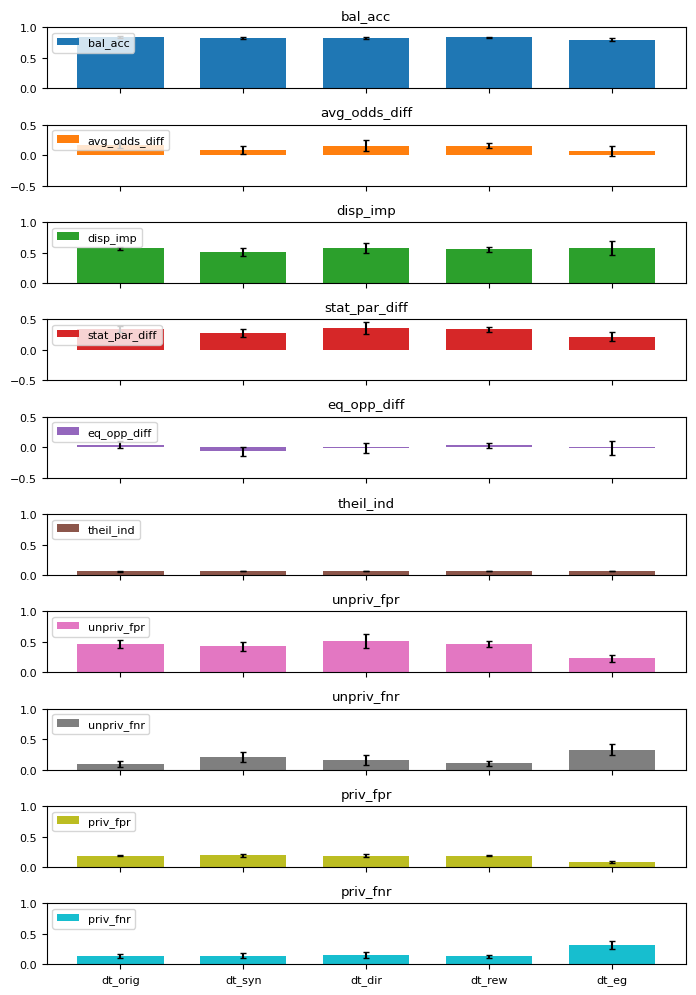

In [39]:
model_type=BASELINE
# Set up plotting options
plt.rcParams.update({'font.size': 8})  # Set global font size
pd.set_option('display.multi_sparse', False)

# Metrics and errors as lists of dictionaries
results = [orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean]
errors = [orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, eg_error_metrics]

# Classifier bias mitigators (for labels)
index = pd.Series(
    [model_type+'_orig', model_type+'_syn', model_type+'_dir', model_type+'_rew', model_type+'_eg'])

# Create DataFrame for metrics and error bars
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)

# Dynamically generate titles for all metrics in df
titles = list(df.columns)

# Plot fairness metrics with error bars
ax = df.plot.bar(
    yerr=df_error, 
    capsize=2, 
    rot=0, 
    subplots=True, 
    title=titles, 
    fontsize=8, 
    figsize=(7, 10),  # Reduced overall figure size
    legend=True,
    width=0.7  # Adjusted bar width to make bars closer
)

# Adjust Y-axis limits dynamically based on metric names
for i, subplot in enumerate(ax):
    metric = titles[i]
    if "fpr" in metric or "fnr" in metric:  # Subgroup-specific metrics
        subplot.set_ylim([0, 1])  # False positive/negative rates range from 0 to 1
    elif metric in ["bal_acc", "disp_imp", "theil_ind"]:  # General metrics
        subplot.set_ylim([0, 1])
    elif metric in ["avg_odds_diff", "stat_par_diff", "eq_opp_diff"]:  # Difference metrics
        subplot.set_ylim([-0.5, 0.5])  # Allow for negative values

    # Move legend inside the plot
    subplot.legend(loc='upper left', fontsize=8, frameon=True)

# Tight layout for better spacing
plt.tight_layout()
plt.show()

## Save Results

In [40]:
# List of method names corresponding to results/errors
method_names = ["orig", "transf", "dir", "rew", "eg"]

# Initialize a list to hold data for the DataFrame
fairness_data = []

# Populate the data list with metrics and errors
for method, metric, error in zip(method_names, results, errors):
    for key in metric.keys():
        fairness_data.append({
            "Method": method,
            "Metric": key,
            "Mean": metric[key][0],  # Assuming the metric values are single-item lists
            "Error": error[key][0]   # Assuming the error values are single-item lists
        })

# Create DataFrame from the data list
fairness_df = pd.DataFrame(fairness_data)

# File path with today's date
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./results/{ATTACK}_{DATASET}_fairness_metrics_{today}.csv"

# Save the DataFrame to CSV
fairness_df.to_csv(file_path, index=True)

print(f"File saved at: {file_path}")

File saved at: ./results/mia2_bank_fairness_metrics_2024-12-30.csv


## Visualization of MIA results


### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [41]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [42]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          eg_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn'] + ['dir'] + ['rew'] + ['eg'], name='Classifier MIA Attacks')
#                   + ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

entire_dataset_mia_privacy_risk  \
Classifier MIA Attacks                                    
orig                                           0.522112   
syn                                            0.520230   
dir                                            0.527573   
rew                                            0.521517   
eg                                             0.526554   

                        subpopulation_0.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.546633   
syn                                                         0.585111   
dir                                                         0.555445   
rew                                                         0.553087   
eg                                                          0.580384   

                        subpopulation_0.0_label_1.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.595856   
syn                                                         0.662800   
dir                                                         0.627568   
rew                                                         0.573774   
eg                                                          0.638673   

                        subpopulation_1.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.511242   
syn                                                         0.507496   
dir                                                         0.518599   
rew                                                         0.510829   
eg                                                          0.512141   

                        subpopulation_1.0_label_1.0_mia_privacy_risk  
Classifier MIA Attacks                                                
orig                                                        0.601383  
syn                                                         0.581668  
dir                                                         0.597005  
rew                                                         0.606154  
eg                                                          0.621886

In [43]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [44]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
                       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [45]:
df_groups

subpopulation_0.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.546633   
syn                                                         0.585111   
dir                                                         0.555445   
rew                                                         0.553087   
eg                                                          0.580384   

                        subpopulation_1.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.511242   
syn                                                         0.507496   
dir                                                         0.518599   
rew                                                         0.510829   
eg                                                          0.512141   

                        subpopulation_0.0_label_1.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.595856   
syn                                                         0.662800   
dir                                                         0.627568   
rew                                                         0.573774   
eg                                                          0.638673   

                        subpopulation_1.0_label_1.0_mia_privacy_risk  
Classifier MIA Attacks                                                
orig                                                        0.601383  
syn                                                         0.581668  
dir                                                         0.597005  
rew                                                         0.606154  
eg                                                          0.621886

<Axes: xlabel='Classifier MIA Attacks'>

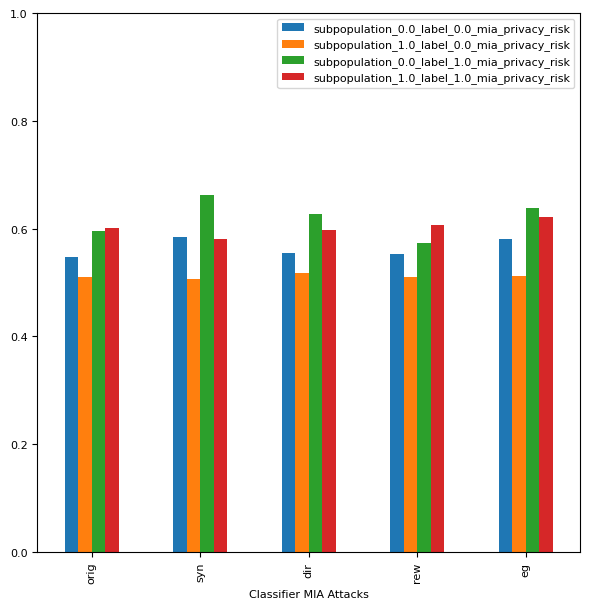

In [46]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [47]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew        eg
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.546633  0.585111  0.555445  0.553087  0.580384
subpopulation_1.0_label_0.0_mia_privacy_risk  0.511242  0.507496  0.518599  0.510829  0.512141
subpopulation_0.0_label_1.0_mia_privacy_risk  0.595856  0.6628    0.627568  0.573774  0.638673
subpopulation_1.0_label_1.0_mia_privacy_risk  0.601383  0.581668  0.597005  0.606154  0.621886


## Save Results

In [48]:
errors

[{'entire_dataset_mia_privacy_risk': 0.0034818248064347563,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.02155949332449747,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.04449306049698256,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.004577373924913692,
  'subpopulation_1.0_label_1.0_mia_privacy_risk': 0.016931737326638788},
 {'entire_dataset_mia_privacy_risk': 0.0030352282406254415,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.017745770940950884,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.028607404380358893,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.005148601488429076,
  'subpopulation_1.0_label_1.0_mia_privacy_risk': 0.019626008979448824},
 {'entire_dataset_mia_privacy_risk': 0.007238660172848786,
  'subpopulation_0.0_label_0.0_mia_privacy_risk': 0.03233234885947112,
  'subpopulation_0.0_label_1.0_mia_privacy_risk': 0.056216717875026,
  'subpopulation_1.0_label_0.0_mia_privacy_risk': 0.009513581153071743,
  'subpopulation_1.0_label_1.0_mi

In [49]:
# List of method names corresponding to results/errors
method_names = ["orig", "transf", "dir", "rew", "eg"]

# Initialize a list to hold data for the DataFrame
pr_data = []

# Populate the data list with metrics and errors
for method, metric, error in zip(method_names, results, errors):
    for key in metric.keys():
        pr_data.append({
            "Method": method,
            "Metric": key,
            "Mean Privacy Risk": metric[key],  # Privacy risk mean
            "Error": error[key]               # Privacy risk error
        })

# Create DataFrame from the data list
pr_df = pd.DataFrame(pr_data)

# File path with today's date
today = datetime.now().strftime('%Y-%m-%d')
file_path = f"./results/{ATTACK}_{DATASET}_mia_privacy_risks_metrics_{today}.csv"

# Save the DataFrame to CSV
pr_df.to_csv(file_path, index=True)

print(f"File saved at: {file_path}")

File saved at: ./results/mia2_bank_mia_privacy_risks_metrics_2024-12-30.csv


# Main Bar Graph Visualization

In [50]:
# Subpopulations and fairness methods
subpopulations = {
    'subpopulation_0.0_label_0.0_mia_privacy_risk': "Unprivileged Unfavorable", 
    'subpopulation_0.0_label_1.0_mia_privacy_risk': "Unprivileged Favorable", 
    'subpopulation_1.0_label_0.0_mia_privacy_risk': "Privileged Unfavorable",
    'subpopulation_1.0_label_1.0_mia_privacy_risk': "Privileged Favorable"
}

fairness_methods = ["syn", "dir", "rew", "eg"]

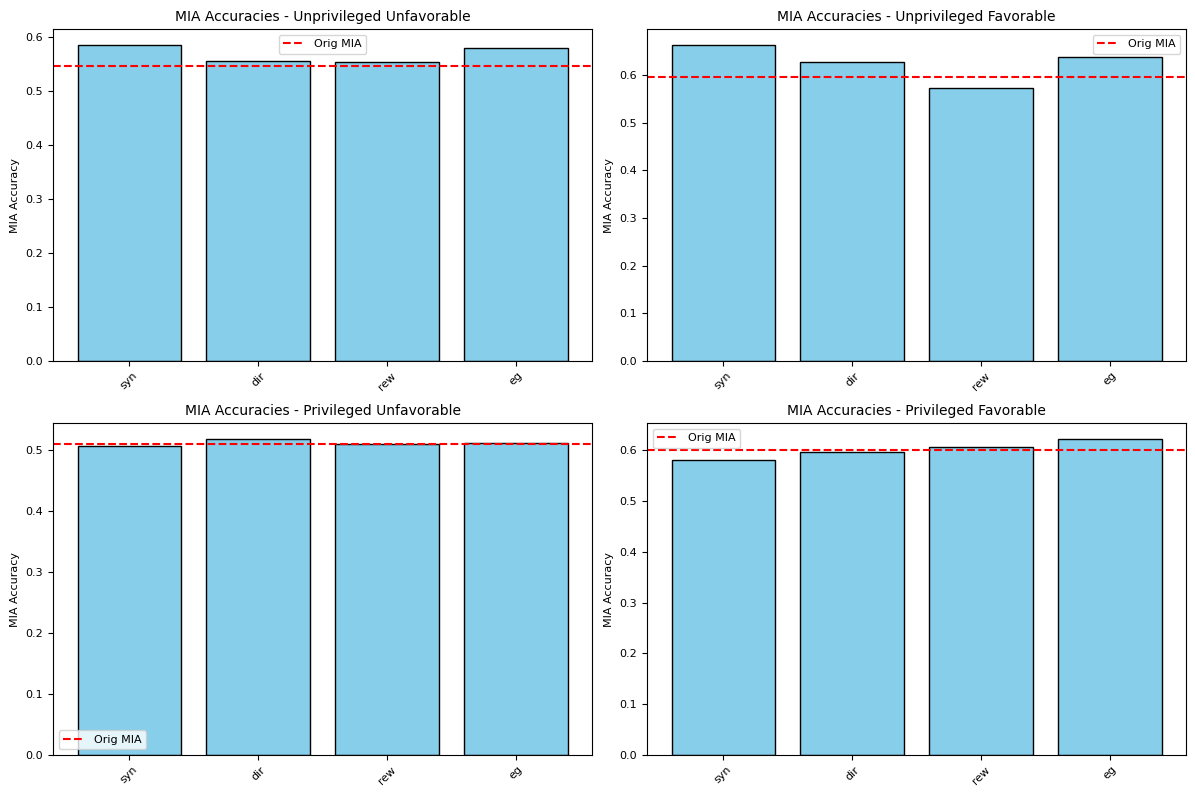

In [51]:
# Combine results into a list
all_results = [
    transf_mia_metrics_mean,
    dir_mia_metrics_mean,
    reweigh_mia_metrics_mean,
    eg_mia_metrics_mean
]

# Organize data for plotting
data = {subpopulations[key]: [results[key] for results in all_results] for key in subpopulations.keys()}
orig_values = orig_mia_metrics_mean

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
idx = 0

for key, value in subpopulations.items():
    accuracies = data[value]
    ax = axes[idx]
    
    # Plot bar chart (excluding 'orig')
    ax.bar(fairness_methods, accuracies, color='skyblue', edgecolor='black')
    
    # Add dashed line for 'orig' MIA accuracy
    ax.axhline(orig_values[key], color='red', linestyle='--', label='Orig MIA')
    
    # Title and labels
    ax.set_title(f"MIA Accuracies - {value}", fontsize=10)
    ax.set_ylabel("MIA Accuracy")
    ax.set_xticks(np.arange(len(fairness_methods)))
    ax.set_xticklabels(fairness_methods, rotation=45)
    ax.legend()
    
    idx = idx + 1

plt.tight_layout()
plt.show()

### Visualizing using novel technique

In [52]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [53]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in eg_mia_error_metrics.keys():
    for val in eg_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["eg", key.replace("_mia_attacker_advantage", ""), val])

In [54]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

Fairness                                           MIA  Privacy Risk
0       orig               entire_dataset_mia_privacy_risk      0.528333
1       orig               entire_dataset_mia_privacy_risk      0.520394
2       orig               entire_dataset_mia_privacy_risk      0.517109
3       orig               entire_dataset_mia_privacy_risk      0.527512
4       orig               entire_dataset_mia_privacy_risk      0.523679
..       ...                                           ...           ...
495       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.628410
496       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.613746
497       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.634529
498       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.619044
499       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.628849

[500 rows x 3 columns]

In [55]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

Fairness                                           MIA  Privacy Risk
0       orig               entire_dataset_mia_privacy_risk      0.528333
1       orig               entire_dataset_mia_privacy_risk      0.520394
2       orig               entire_dataset_mia_privacy_risk      0.517109
3       orig               entire_dataset_mia_privacy_risk      0.527512
4       orig               entire_dataset_mia_privacy_risk      0.523679
..       ...                                           ...           ...
495       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.628410
496       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.613746
497       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.634529
498       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.619044
499       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.628849

[500 rows x 3 columns]

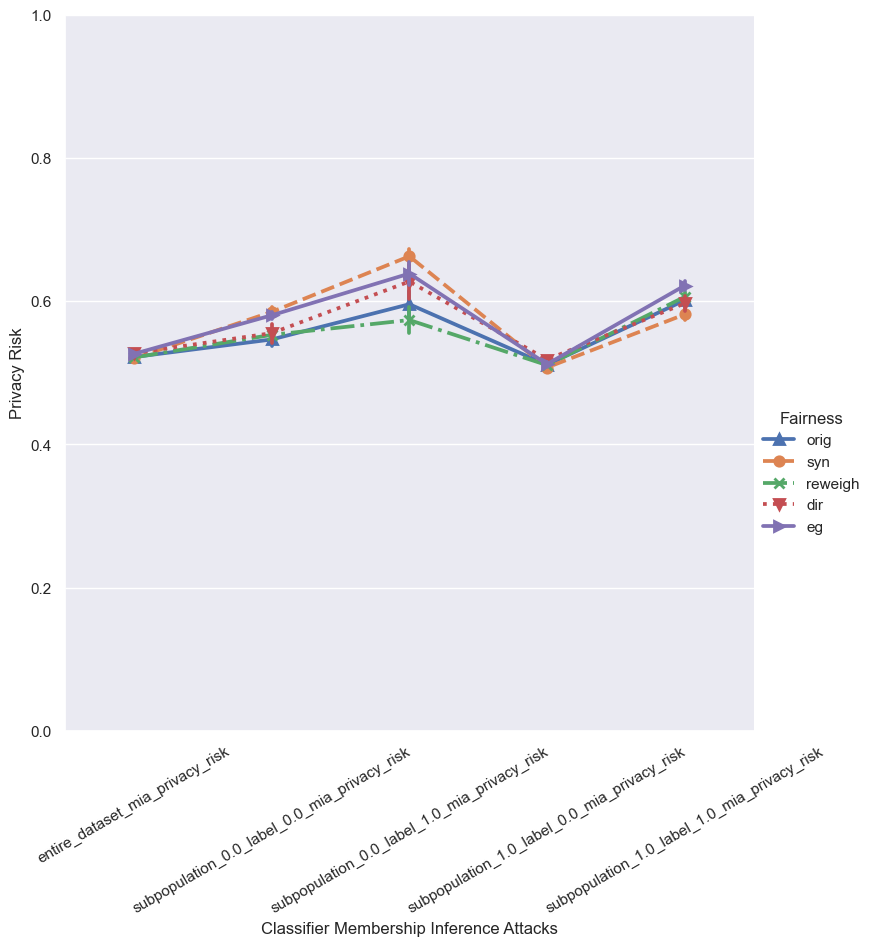

In [56]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [57]:
from sklearn.metrics import RocCurveDisplay, auc

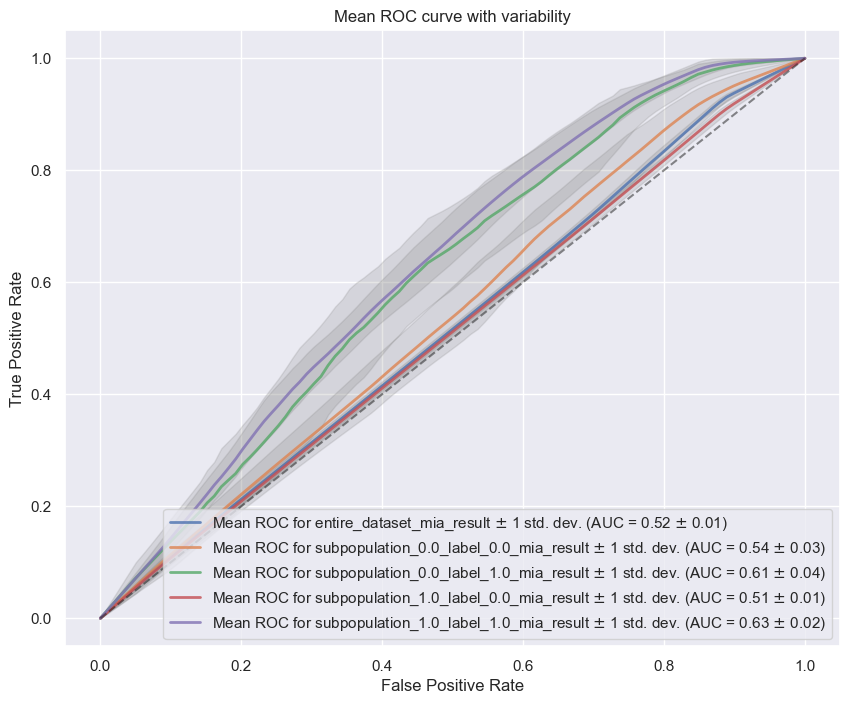

In [58]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", 
            "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", 
            "subpopulation_1.0_label_0.0_mia_result",
            "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.06
  Positive predictive value: 0.57
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: [0.7472144]
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.03
  Positive predictive value: 0.53
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 3653, Test = 3653
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  T

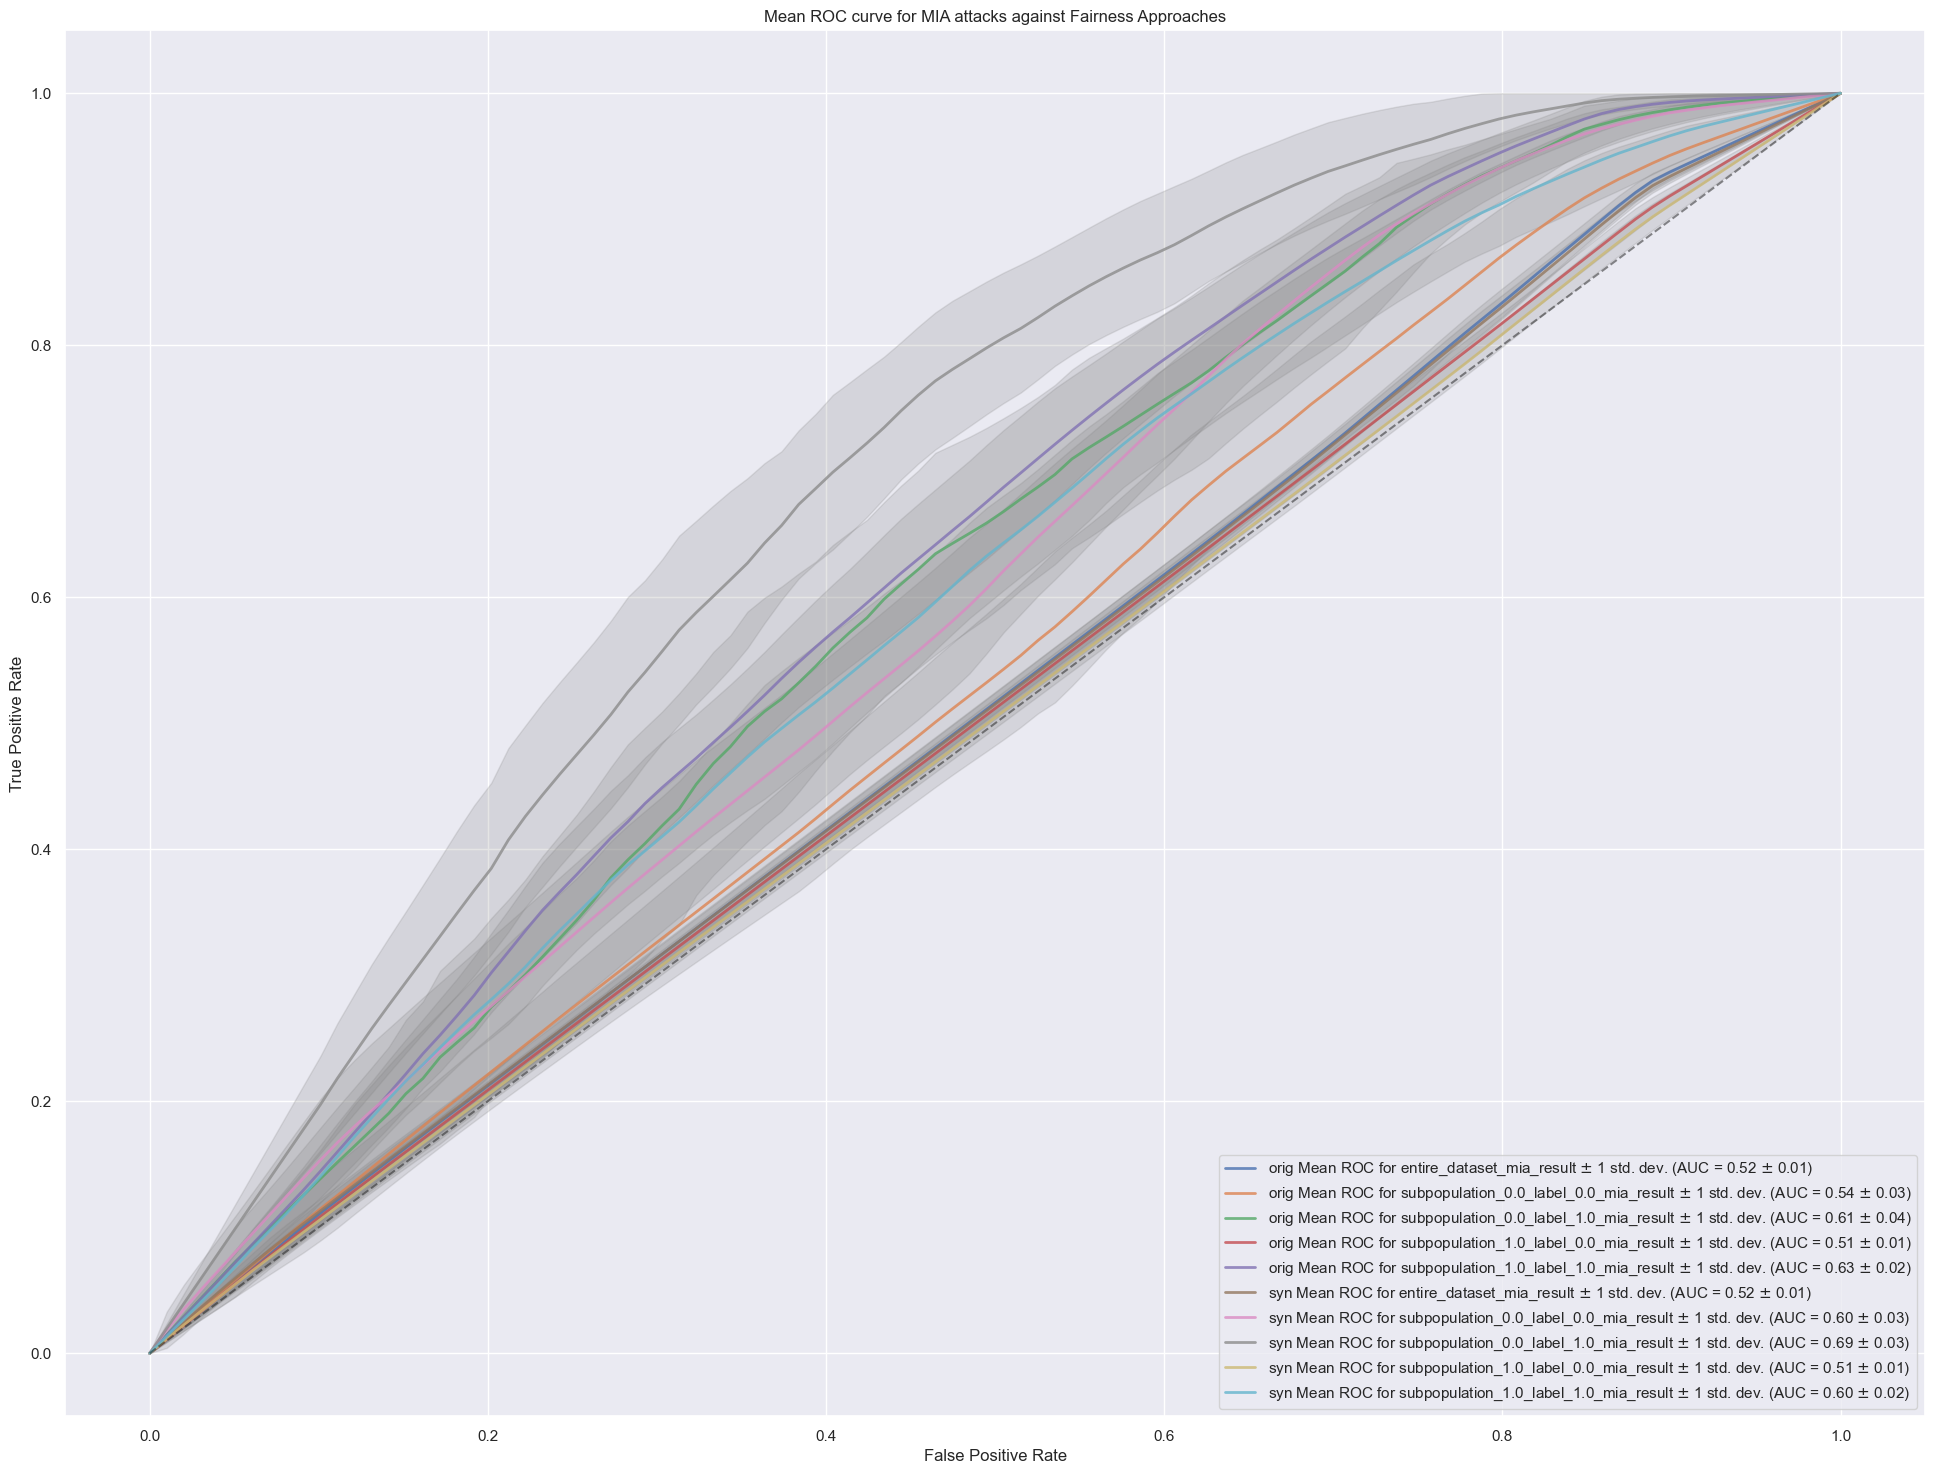

In [59]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics], ["orig", "syn"]): 
#                               dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", 
                "subpopulation_0.0_label_0.0_mia_result",
                "subpopulation_0.0_label_1.0_mia_result", 
                "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            print(mia_res)
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        print(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

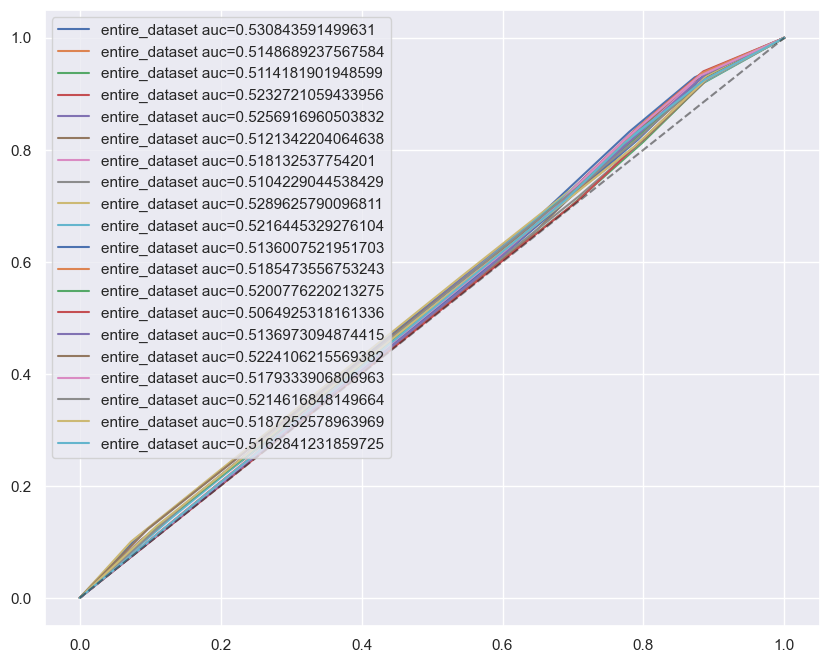

In [60]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [61]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("mia_auc")}

In [62]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

entire_dataset_mia_auc  \
Classifier MIA Attacks                           
orig                                  0.518331   
syn                                   0.517501   
dir                                   0.523215   
rew                                   0.515374   
egr                                   0.515773   

                        subpopulation_0.0_label_0.0_mia_auc  \
Classifier MIA Attacks                                        
orig                                               0.538022   
syn                                                0.596608   
dir                                                0.553445   
rew                                                0.542741   
egr                                                0.566259   

                        subpopulation_0.0_label_1.0_mia_auc  \
Classifier MIA Attacks                                        
orig                                               0.609645   
syn                                                0.693602   
dir                                                0.640860   
rew                                                0.575808   
egr                                                0.650529   

                        subpopulation_1.0_label_0.0_mia_auc  \
Classifier MIA Attacks                                        
orig                                               0.511428   
syn                                                0.505743   
dir                                                0.516155   
rew                                                0.507379   
egr                                                0.507463   

                        subpopulation_1.0_label_1.0_mia_auc  
Classifier MIA Attacks                                       
orig                                               0.626190  
syn                                                0.595825  
dir                                                0.615894  
rew                                                0.634926  
egr                                                0.653780

<Axes: xlabel='Classifier MIA Attacks'>

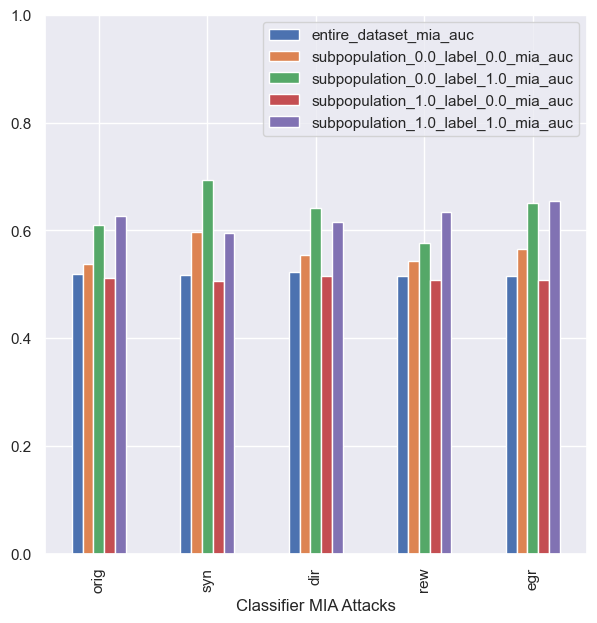

In [63]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [64]:
# Creating data structures to plot point categorical plot from seaborn

In [65]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [66]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.05666575417465092],
 ['orig', 'entire_dataset', 0.04078839310156046],
 ['orig', 'entire_dataset', 0.034218450588557325],
 ['orig', 'entire_dataset', 0.05502326854640027],
 ['orig', 'entire_dataset', 0.047358335614563374],
 ['orig', 'entire_dataset', 0.04982206405693956],
 ['orig', 'entire_dataset', 0.048179578428688696],
 ['orig', 'entire_dataset', 0.0372296742403504],
 ['orig', 'entire_dataset', 0.044894607172187184],
 ['orig', 'entire_dataset', 0.04078839310156035],
 ['orig', 'entire_dataset', 0.047905830823980367],
 ['orig', 'entire_dataset', 0.0539282781275664],
 ['orig', 'entire_dataset', 0.03805091705447572],
 ['orig', 'entire_dataset', 0.03777716944976728],
 ['orig', 'entire_dataset', 0.04708458800985493],
 ['orig', 'entire_dataset', 0.03613468382151663],
 ['orig', 'entire_dataset', 0.05228579249931564],
 ['orig', 'entire_dataset', 0.039967150287434916],
 ['orig', 'entire_dataset', 0.036955926635641956],
 ['orig', 'entire_dataset', 0.039419655078018

In [67]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

Fairness                          MIA  attacker_advantage
0       orig               entire_dataset            0.056666
1       orig               entire_dataset            0.040788
2       orig               entire_dataset            0.034218
3       orig               entire_dataset            0.055023
4       orig               entire_dataset            0.047358
..       ...                          ...                 ...
495      egr  subpopulation_1.0_label_1.0            0.256820
496      egr  subpopulation_1.0_label_1.0            0.227492
497      egr  subpopulation_1.0_label_1.0            0.269059
498      egr  subpopulation_1.0_label_1.0            0.238089
499      egr  subpopulation_1.0_label_1.0            0.257699

[500 rows x 3 columns]

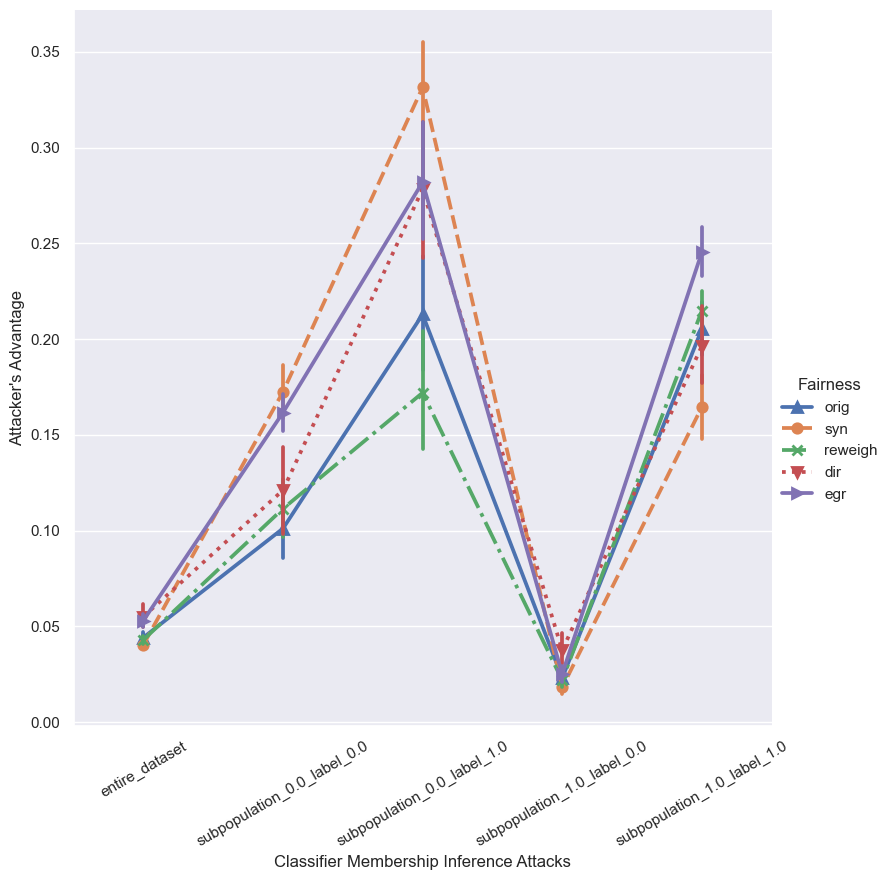

In [68]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


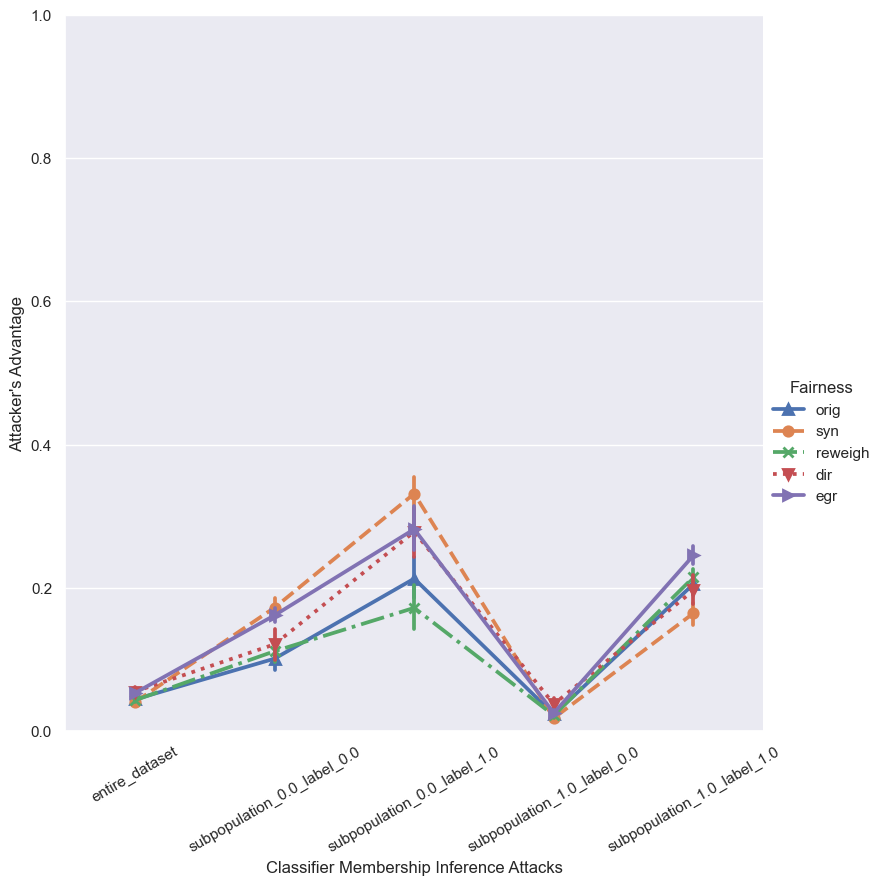

In [69]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [70]:
pd.DataFrame(orig_mia_metrics_att_ad)

entire_dataset_mia_attacker_advantage  \
0                                0.056666   
1                                0.040788   
2                                0.034218   
3                                0.055023   
4                                0.047358   
5                                0.049822   
6                                0.048180   
7                                0.037230   
8                                0.044895   
9                                0.040788   
10                               0.047906   
11                               0.053928   
12                               0.038051   
13                               0.037777   
14                               0.047085   
15                               0.036135   
16                               0.052286   
17                               0.039967   
18                               0.036956   
19                               0.039420   

    subpopulation_0.0_label_0.0_mia_attacker_advantage  \
0                                            0.141186    
1                                            0.100000    
2                                            0.177536    
3                                            0.106923    
4                                            0.083251    
5                                            0.114320    
6                                            0.137359    
7                                            0.055526    
8                                            0.140598    
9                                            0.062894    
10                                           0.060144    
11                                           0.150816    
12                                           0.045081    
13                                           0.084117    
14                                           0.083355    
15                                           0.099206    
16                                           0.068323    
17                                           0.113430    
18                                           0.131490    
19                                           0.067178    

    subpopulation_0.0_label_1.0_mia_attacker_advantage  \
0                                            0.287649    
1                                            0.233929    
2                                            0.216270    
3                                            0.224359    
4                                            0.217806    
5                                            0.244538    
6                                            0.147265    
7                                            0.155172    
8                                            0.220033    
9                                            0.148728    
10                                           0.222172    
11                                           0.321972    
12                                           0.158426    
13                                           0.151924    
14                                           0.180573    
15                                           0.156892    
16                                           0.159388    
17                                           0.286232    
18                                           0.126482    
19                                           0.397727    

    subpopulation_1.0_label_0.0_mia_attacker_advantage  \
0                                            0.030657    
1                                            0.006535    
2                                            0.013551    
3                                            0.028978    
4                                            0.033853    
5                                            0.017018    
6                                            0.027227    
7                                            0.023362    
8                                            0.024676    
9                                       

In [71]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [72]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

entire_dataset_mia_attacker_advantage  \
Classifier MIA Attacks                                          
orig                                                 0.044224   
syn                                                  0.040460   
dir                                                  0.055146   
rew                                                  0.043033   
egr                                                  0.053107   

                        subpopulation_0.0_label_0.0_mia_attacker_advantage  \
Classifier MIA Attacks                                                       
orig                                                             0.101137    
syn                                                              0.172458    
dir                                                              0.121137    
rew                                                              0.111495    
egr                                                              0.161665    

                        subpopulation_0.0_label_1.0_mia_attacker_advantage  \
Classifier MIA Attacks                                                       
orig                                                             0.212877    
syn                                                              0.331455    
dir                                                              0.278356    
rew                                                              0.172018    
egr                                                              0.281938    

                        subpopulation_1.0_label_0.0_mia_attacker_advantage  \
Classifier MIA Attacks                                                       
orig                                                             0.023151    
syn                                                              0.018155    
dir                                                              0.037566    
rew                                                              0.021886    
egr                                                              0.025141    

                        subpopulation_1.0_label_1.0_mia_attacker_advantage  
Classifier MIA Attacks                                                      
orig                                                             0.205157   
syn                                                              0.164505   
dir                                                              0.196366   
rew                                                              0.214803   
egr                                                              0.245305

<Axes: xlabel='Classifier MIA Attacks'>

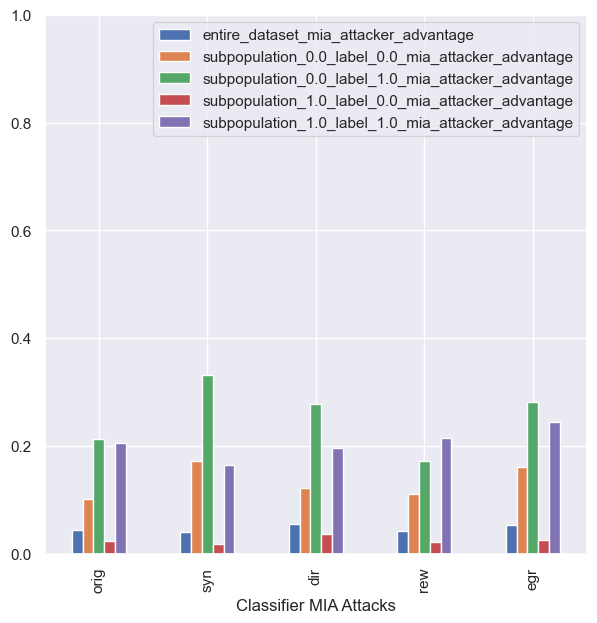

In [73]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [74]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("mia_ppv")}

In [75]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.5705967976710336],
 ['orig', 'entire_dataset', 0.5111912272795553],
 ['orig', 'entire_dataset', 0.52991452991453],
 ['orig', 'entire_dataset', 0.5425219941348973],
 ['orig', 'entire_dataset', 0.5422740524781341],
 ['orig', 'entire_dataset', 0.5138931297709923],
 ['orig', 'entire_dataset', 0.5134886572654813],
 ['orig', 'entire_dataset', 0.510128090557045],
 ['orig', 'entire_dataset', 0.5800316957210777],
 ['orig', 'entire_dataset', 0.5231243576567318],
 ['orig', 'entire_dataset', 0.51312040785725],
 ['orig', 'entire_dataset', 0.5148098030371372],
 ['orig', 'entire_dataset', 0.5392405063291139],
 ['orig', 'entire_dataset', 0.5103946971979512],
 ['orig', 'entire_dataset', 0.5129012901290129],
 ['orig', 'entire_dataset', 0.559850374064838],
 ['orig', 'entire_dataset', 0.5144281613536789],
 ['orig', 'entire_dataset', 0.5296198054818745],
 ['orig', 'entire_dataset', 0.5404157043879908],
 ['orig', 'entire_dataset', 0.5124180751983443],
 ['orig', 'subpopulation_0

In [76]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

Fairness                          MIA       PPV
0       orig               entire_dataset  0.570597
1       orig               entire_dataset  0.511191
2       orig               entire_dataset  0.529915
3       orig               entire_dataset  0.542522
4       orig               entire_dataset  0.542274
..       ...                          ...       ...
495      egr  subpopulation_1.0_label_1.0  0.650000
496      egr  subpopulation_1.0_label_1.0  0.587902
497      egr  subpopulation_1.0_label_1.0  0.750000
498      egr  subpopulation_1.0_label_1.0  0.666667
499      egr  subpopulation_1.0_label_1.0  0.734694

[500 rows x 3 columns]

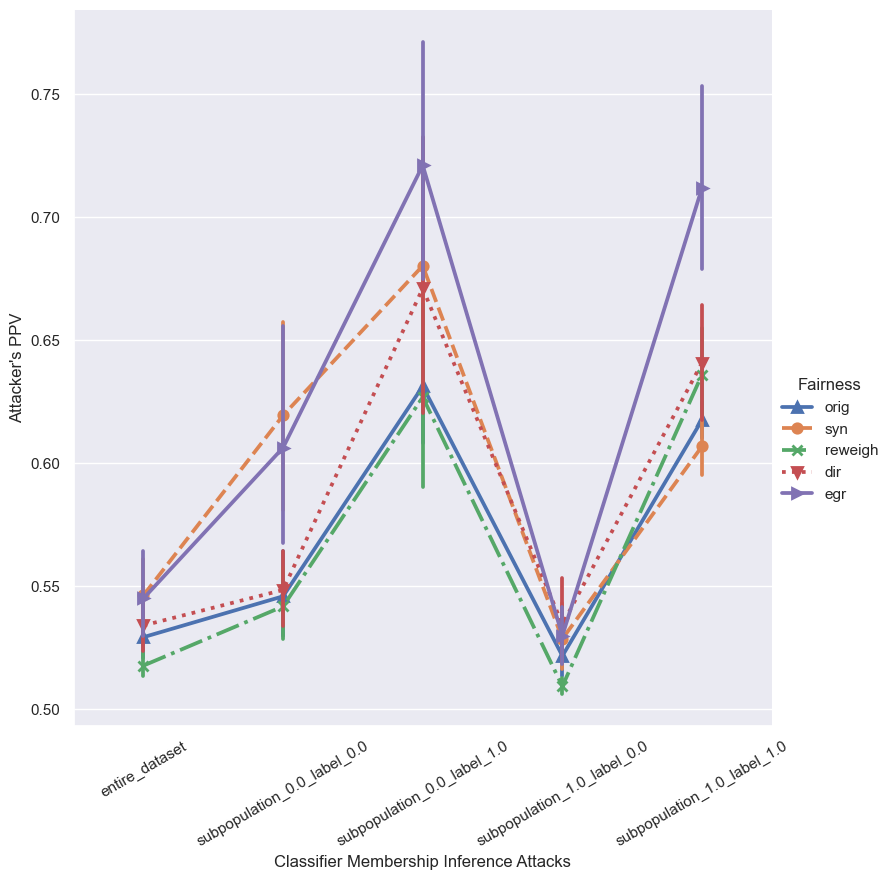

In [77]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )
